<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Entrenamiento de redes *Feed-Forward* vı́a GD y variantes (SGD, mini-*batches*), *momentum*, regularización y tasa de aprendizaje adaptiva.
* Evaluación de redes *Feed-Forward* vı́a validación cruzada (cross-validation).
* Rol de capas ocultas y mayor profundidad (*Deep Learning*).
* Identificar el gradiente desvaneciente.
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 26 de Octubre.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea1-INF395-II-2018]

<hr style="height:2px;border:none"/>

#### Paquetes instalación

Para poder trabajar en el curso se necesitará instalar librerías para Python, por lo que se recomienda instalarlas a través de anaconda (para Windows y sistemas Unix) en un entorno virtual, donde podrán elegir su versión de Python. Se instalarán librerías como sklearn, una librería simple y de facil acceso para data science, keras en su versión con GPU (para cálculo acelerado a través de la tarjeta gráfica), además de que ésta utiliza como backend TensorFlow o Theano, por lo que habrá que instalar alguno de éstos, además de las librerías básicas de computer science como *numpy, matplotlib, pandas,* además de claramente *jupyter*.

* Descargar anacona
* Luego de instalar Anaconda y tenerla en el path de su computador crear un entorno virtual:
```
conda create -n redesneuronales python=version
```
con version, la version de Python que desea utilizar. Si está en Windows, se recomienda Python 3 debido a dependencias con una de las librerías a utilziar.

* Acceder al ambiente creado
```
source activate redesneuronales
```

* Instalar los paquetes a utilizar
```
conda install jupyter sklearn numpy pandas matplotlib keras-gpu tensorflow-gpu
```

*  Para salir del entorno
```
source deactivate redesneuronales
```

<hr style="height:2px;border:none"/>
La tarea se divide en secciones:

[1.](#primero) Predicción de Entalpía de Atomización  
[2.](#segundo) *Deep Networks*  
[3.](#tercero) Entendimiento de imágenes de personas

<a id="primero"></a>
## 1. Predicción de Entalpía de Atomización


Las simulaciones de propiedades moleculares son computacionalmente costosas y requieren de un arduo trabajo científico. El objetivo de esta sección corresponde a la utilización de métodos de aprendizaje automático supervisado (Redes Neuronales Artificiales) para predecir propiedades moleculares, en este caso la Energía de Atomización o Entalpía de Atomización, a partir de una base de datos de simulaciones obtenida mediante __[Quantum Espresso](http://www.quantum-espresso.org/)__. Si esto se lograse hacer con gran precisión, se abrirían muchas posibilidades en el diseño computacional y el descubrimiento de nuevas moléculas, compuestos y fármacos.

<img src="https://pubs.rsc.org/services/images/RSCpubs.ePlatform.Service.FreeContent.ImageService.svc/ImageService/Articleimage/2012/NR/c2nr11543c/c2nr11543c-f4.gif" title="Title text" width="40%"/>


La **entalpía de atomización** es la cantidad de variación de entalpía cuando los enlaces de un compuesto se rompen y los componentes se reducen a átomos individuales. Tal como se ha indicado, su tarea es la de predecir dicho nivel a partir de los atributos enunciados en el dataset puesto a vuestra disposición en *moodle*.

> a) Construya un *dataframe* con los datos a analizar y descríbalo brevemete. Además, realice la división de éste en los conjuntos de entrenamiento, validación y testeo correspondientes. Comente por qué se deben eliminar ciertas columnas.
```python
import pandas as pd
datos= pd.read_csv("EnergyMolecule/roboBohr.csv")
datos.shape
datos.info()
datos.describe()
...
datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante
```
>> a.1) Una buena práctica es la de normalizar los datos antes de trabajar con el modelo. **Explique por qué se aconseja dicho preprocesamiento**
>```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)
...
y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)
...
X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)
```

 
>b) Muestre en un gráfico el error cuadrático (MSE) para el conjunto de entrenamiento y de pruebas vs número de *epochs* de entrenamiento, para una red *feedforward* de 3 capas, con 256 unidades ocultas y función de activación sigmoidal. Entrene la red usando gradiente descendente estocástico con tasa de aprendizaje (learning rate) 0.01 y 250 epochs de entrenamiento, en el conjunto de entrenamiento y de validación. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
```
> c) Repita el paso anterior, utilizado ’**ReLU**’ como función de activación y compare con lo obtenido en b).  

> d) Repita b) y c) variando la tasa de aprendizaje (*learning rate*) en un rango sensible. Comente. Si observara divergencia durante el entrenamiento, determine si esto ocurre para cada repetición del experimento.
```python
import numpy as np
n_lr = 20
lear_rate = np.linspace(0,1,n_lr)
```

> e) Entrene los modelos considerados en b) y c) usando *progressive decay*. Compare y comente.
```python
n_decay = 10
lear_decay = np.logspace(-6,0,n_decay)
sgd = SGD(lr=0.2, decay=1e-6)
```

> f) Entrene los modelos considerados en b) y c) utilizando SGD en mini-*batches*. Experimente con diferentes tamaños del *batch*. Comente.
```python
n_batches = 21
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
model.fit(X_train_scaled,y_train,batch_size=50,epochs=250,validation_data=(X_val_scaled, y_val))
```
> g) Entrene los modelos obtenidos en b) y c) utilizando estrategias modernas para adaptar la tasa de aprendizaje. Compare los desempeños de adagrad, adadelta, RMSprop y adam. ¿Se observa en algún caso un mejor resultado final? ¿Se observa en algún caso una mayor velocidad de convergencia sobre el dataset de entrenamiento? ¿Sobre el dataset de validación?
```python
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer)
model.fit(X_train_scaled,y_train,batch_size=bs,epochs=250,validation_data=(X_val_scaled, y_val))
```

> h) Entrene los modelos obtenidos en b) y c) utilizando regularizadores $l_1$ y $l_2$ (*weight decay*). Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente. Además evalúe el efecto de regularizar solo la primera capa *vs* la segunda, comente.
```python
model = Sequential()
...#la regularization se debe incorporar a cada capa separadamente
idim=X_train_scaled.shape[1]
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=l2(0.01)))
model.add(Activation('linear'))
```

> i) Entrene los modelos obtenidos en b) y c) utilizando *Dropout*. Compare los desempeños de prueba obtenidos antes y después de regularizar. Experimente con distintos valores del parámetro de regularización y comente.
```python
from keras.layers import Dropout
model = Sequential()
...
model.add(Dense(256,kernel_initializer='uniform'))
model.add(Activation('sigmoid'))
model.add(Dropout(0.2))
...
```

> j) Fijando todos los demás hiper-parámetros del modelo definido en b) y en c), utilice validación cruzada con un número de *folds* igual a *K* = 5 y *K*=10 para determinar el mejor valor correspondiente a un parámetro que usted elija (tasa de aprendizaje, número de neuronas, parámetro de regularización, etc) ¿El mejor parámetro para la red con sigmoidal es distinto que para ReLU? ¿Porqué sucede? Además mida el error real del modelo sobre el conjunto de pruebas, compare y concluya.
```python
from sklearn import cross_validation
Xm = X_train_scaled.values
ym = y_train
kfold = cross_validation.KFold(len(Xm), 10)
cvscores = []
for i, (train, val) in enumerate(kfold):
    ...# create model
    model = #model with hiperparam
    ...# Compile model
    model.compile(optimizer=,loss='mean_squared_error')
    ...# Fit the model
    model.fit(Xm[train], ym[train], epochs=250)
    ...# evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)
```

# Respuesta Pregunta 1

a) Descripción de los datos

In [1]:
import pandas as pd
datos= pd.read_csv("roboBohr.csv")

datos.drop(columns=['Unnamed: 0','pubchem_id'],axis=1,inplace=True)
total=len(datos)
df_train=datos[:int(0.6*total)]                       #60% de los datos
df_val=datos[int(0.6*total):int(0.85*total)]          #25% de los datos
df_test=datos[int(0.85*total)::]                      #15% restante

a.1) Normalizando

In [2]:
# Setting training and evaluation data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
X_val_scaled =  pd.DataFrame(scaler.transform(df_val),columns=df_val.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(df_test),columns=df_test.columns)

y_train = df_train.pop('Eat').values.reshape(-1,1)
y_val = df_val.pop('Eat').values.reshape(-1,1)

X_train_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_val_scaled.drop(columns=['Eat'],axis=1,inplace=True)
X_test_scaled.drop(columns=['Eat'],axis=1,inplace=True)

b)

In [3]:
# Creating and training model
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
model = Sequential()

/Users/cmaldona/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.01),loss='mean_squared_error')
history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 209us/step - loss: 1.4463 - val_loss: 0.5312
Epoch 2/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.6106 - val_loss: 0.4332
Epoch 3/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.4987 - val_loss: 0.3856
Epoch 4/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.4316 - val_loss: 0.3665
Epoch 5/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.3621 - val_loss: 0.3535
Epoch 6/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.3243 - val_loss: 0.3013
Epoch 7/250
9745/9745 [==============================] - 2s 204us/step - loss: 0.2854 - val_loss: 0.2445
Epoch 8/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.2528 - val_loss: 0.2182
Epoch 9/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.2193 - val_loss: 0.1962
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.0304 - val_loss: 0.0431
Epoch 79/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.0299 - val_loss: 0.0551
Epoch 80/250
9745/9745 [==============================] - 2s 161us/step - loss: 0.0309 - val_loss: 0.0500
Epoch 81/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.0293 - val_loss: 0.0463
Epoch 82/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.0284 - val_loss: 0.0443
Epoch 83/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0288 - val_loss: 0.0423
Epoch 84/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0291 - val_loss: 0.0409
Epoch 85/250
9745/9745 [==============================] - 2s 154us/step - loss: 0.0289 - val_loss: 0.0496
Epoch 86/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0278 - val_loss: 0.0712
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.0201 - val_loss: 0.0383
Epoch 156/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0203 - val_loss: 0.0363
Epoch 157/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.0192 - val_loss: 0.0390
Epoch 158/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.0198 - val_loss: 0.0380
Epoch 159/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.0195 - val_loss: 0.0412
Epoch 160/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.0196 - val_loss: 0.0381
Epoch 161/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.0195 - val_loss: 0.0410
Epoch 162/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0189 - val_loss: 0.0593
Epoch 163/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0193 - val_loss: 0.0395
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 1s 154us/step - loss: 0.0153 - val_loss: 0.0375
Epoch 232/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0155 - val_loss: 0.0384
Epoch 233/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0155 - val_loss: 0.0385
Epoch 234/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0159 - val_loss: 0.0345
Epoch 235/250
9745/9745 [==============================] - 2s 154us/step - loss: 0.0150 - val_loss: 0.0371
Epoch 236/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0160 - val_loss: 0.0367
Epoch 237/250
9745/9745 [==============================] - 2s 157us/step - loss: 0.0154 - val_loss: 0.0359
Epoch 238/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0151 - val_loss: 0.0348
Epoch 239/250
9745/9745 [==============================] - 2s 160us/step - loss: 0.0152 - val_loss: 0.0347
Epoch 240/250
9745/9745 [==========================

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

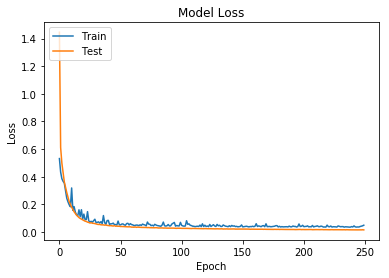

In [6]:
# Ploting Loss And Val_Loss

# Data
val_loss = history.history['val_loss']
loss = history.history['loss']

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#fig.savefig("test.png")
plt.show()


c)

In [10]:
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
model.compile(optimizer=SGD(lr=0.001),loss='mean_squared_error')
history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 176us/step - loss: 10.2817 - val_loss: 2.4034
Epoch 2/250
9745/9745 [==============================] - 2s 166us/step - loss: 1.6026 - val_loss: 1.6458
Epoch 3/250
9745/9745 [==============================] - 2s 164us/step - loss: 0.8790 - val_loss: 1.0036
Epoch 4/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.5400 - val_loss: 0.9441
Epoch 5/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.5774 - val_loss: 0.9980
Epoch 6/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.4463 - val_loss: 0.7764
Epoch 7/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.3509 - val_loss: 1.1096
Epoch 8/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.2892 - val_loss: 0.7060
Epoch 9/250
9745/9745 [==============================] - 2s 191us/step - loss: 0.2651 - val_loss: 0.7830
Epoch 

Epoch 78/250
9745/9745 [==============================] - 2s 154us/step - loss: 0.0549 - val_loss: 0.1381
Epoch 79/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0495 - val_loss: 0.1512
Epoch 80/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0488 - val_loss: 0.1423
Epoch 81/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0472 - val_loss: 0.1549
Epoch 82/250
9745/9745 [==============================] - 2s 190us/step - loss: 0.0459 - val_loss: 0.1357
Epoch 83/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0502 - val_loss: 0.1376
Epoch 84/250
9745/9745 [==============================] - 2s 162us/step - loss: 0.0495 - val_loss: 0.1816
Epoch 85/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.0492 - val_loss: 0.1317
Epoch 86/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.0477 - val_loss: 0.1513
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.0315 - val_loss: 0.1057
Epoch 156/250
9745/9745 [==============================] - 1s 149us/step - loss: 0.0301 - val_loss: 0.1259
Epoch 157/250
9745/9745 [==============================] - 1s 151us/step - loss: 0.0296 - val_loss: 0.1032
Epoch 158/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0294 - val_loss: 0.1071
Epoch 159/250
9745/9745 [==============================] - 2s 159us/step - loss: 0.0291 - val_loss: 0.1554
Epoch 160/250
9745/9745 [==============================] - 1s 151us/step - loss: 0.0295 - val_loss: 0.1057
Epoch 161/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0289 - val_loss: 0.1163
Epoch 162/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.0282 - val_loss: 0.1286
Epoch 163/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0286 - val_loss: 0.1130
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 2s 177us/step - loss: 0.0232 - val_loss: 0.1077
Epoch 232/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0227 - val_loss: 0.1121
Epoch 233/250
9745/9745 [==============================] - 1s 152us/step - loss: 0.0230 - val_loss: 0.1148
Epoch 234/250
9745/9745 [==============================] - 1s 152us/step - loss: 0.0219 - val_loss: 0.1094
Epoch 235/250
9745/9745 [==============================] - 2s 155us/step - loss: 0.0223 - val_loss: 0.1195
Epoch 236/250
9745/9745 [==============================] - 2s 156us/step - loss: 0.0227 - val_loss: 0.1101
Epoch 237/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0216 - val_loss: 0.1072
Epoch 238/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0218 - val_loss: 0.1084
Epoch 239/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.0221 - val_loss: 0.1044
Epoch 240/250
9745/9745 [==========================

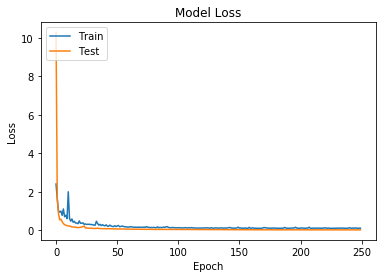

In [11]:
# Ploting Loss And Val_Loss

# Data
val_loss = history2.history['val_loss']
loss = history2.history['loss']

# Ploting
plt.plot(val_loss)
plt.plot(loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#fig.savefig("test.png")
plt.show()

d)

In [12]:
histories = dict() # Key = learn_rate, Value = history
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)
for learn_r in learn_rate:
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=learn_r),loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(learn_r)+')'] = history.history['loss']
    histories['val loss('+str(learn_r)+')'] = history.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-D-1.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 2/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 3/250
9745/9745 [==============================] - 2s 212us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 4/250
9745/9745 [==============================] - 2s 161us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 5/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 6/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 7/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 8/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 9/250
9745/9745 [==============================] - 2s 157us/step - loss: 1

9745/9745 [==============================] - 2s 165us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 76/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 77/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 78/250
9745/9745 [==============================] - 2s 169us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 79/250
9745/9745 [==============================] - 2s 173us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 80/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 81/250
9745/9745 [==============================] - 2s 168us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 82/250
9745/9745 [==============================] - 2s 166us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 83/250
9745/9745 [==============================] - 2s 174us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 84/250
9745/9745 

9745/9745 [==============================] - 2s 162us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 150/250
9745/9745 [==============================] - 2s 173us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 151/250
9745/9745 [==============================] - 2s 168us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 152/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 153/250
9745/9745 [==============================] - 2s 164us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 154/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 155/250
9745/9745 [==============================] - 2s 186us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 156/250
9745/9745 [==============================] - 2s 177us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 157/250
9745/9745 [==============================] - 2s 167us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 158/250
9

Epoch 223/250
9745/9745 [==============================] - 2s 155us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 224/250
9745/9745 [==============================] - 2s 154us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 225/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 226/250
9745/9745 [==============================] - 1s 153us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 227/250
9745/9745 [==============================] - 1s 153us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 228/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 229/250
9745/9745 [==============================] - 2s 155us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 230/250
9745/9745 [==============================] - 2s 154us/step - loss: 135.1554 - val_loss: 154.6922
Epoch 231/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.1554 - val_loss: 154.6922
E

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 58/250
9745/9745 [==============================] - 2s 154us/step - loss: nan - val_loss: nan
Epoch 59/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 60/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 61/250


9745/9745 [==============================] - 2s 220us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 207us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 235us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoch 220/250
9745/9745 [==============================] - 2s 254us/step - loss: nan - val_loss: nan
Epoch 221/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 222/250
9745/9745 [==============================] - 3s 293us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 1s 153us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 54/250


Epoch 126/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 48/250


Epoch 120/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 42/250


Epoch 114/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 36/250


Epoch 108/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 30/250


9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 213us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 210us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

Epoch 14/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan


Epoch 96/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss

9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 178/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 179/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 180/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoch 181/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 182/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 183/250
9745/9745 [==============================] - 2s 218us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoc

Epoch 8/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 12/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 13/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 14/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Ep

Epoch 90/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 93/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 94/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 95/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 96/250
9745/9745 [==============================] - 1s 149us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan


9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 174/250
9745/9745 [==============================] - 1s 154us/step - loss: nan - val_loss: nan
Epoch 175/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 176/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 177/250
9745/9745 [==============================] - 1s 152us/step - loss: nan - val_loss: nan
Epoch 178/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 179/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 180/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 5/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 6/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 7/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 8/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/974

9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 86/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 87/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 88/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoch 89/250
9745/9745 [==============================] - 2s 203us/step - loss: nan - val_loss: nan
Epoch 90/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 209us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 93/250


9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 167/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 168/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 169/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 170/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 171/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 248/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 249/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 250/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 193

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 79/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 80/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 81/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 82/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 83/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 86/250


9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 160/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 161/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 162/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 163/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 164/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 241/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 242/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 243/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 244/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 245/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 72/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 73/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 74/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 75/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 76/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 203us/step - loss: nan - val_loss: nan
Epoch 79/250


9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 153/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 154/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 155/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 156/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 157/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 234/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 235/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 236/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 237/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 238/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 218us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 65/250
9745/9745 [==============================] - 2s 211us/step - loss: nan - val_loss: nan
Epoch 66/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 67/250
9745/9745 [==============================] - 2s 250us/step - loss: nan - val_loss: nan
Epoch 68/250
9745/9745 [==============================] - 2s 219us/step - loss: nan - val_loss: nan
Epoch 69/250
9745/9745 [==============================] - 2s 235us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 3s 259us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 226us/step - loss: nan - val_loss: nan
Epoch 72/250


9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 146/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 147/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 148/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 149/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 150/250
9745/9745 [==============================] - 2s 199us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 207us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 227/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 228/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 229/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 230/250
9745/9745 [==============================] - 2s 220us/step - loss: nan - val_loss: nan
Epoch 231/250
9745/9745 [==============================] - 2s 214us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 189us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 207us/step - loss: nan - val_loss: nan
Epoch 58/250
9745/9745 [==============================] - 2s 209us/step - loss: nan - val_loss: nan
Epoch 59/250
9745/9745 [==============================] - 2s 224us/step - loss: nan - val_loss: nan
Epoch 60/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 61/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 62/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 65/250


9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 142/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 143/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 220/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 221/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 222/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 223/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 224/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 58/250


9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 256us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 3s 260us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 238us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 210us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 214us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 185us/step - loss: nan - val_loss: nan
Epoch 51/250


Epoch 123/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_

9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 182us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 240us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 221us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 45/250


Epoch 117/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 154us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 39/250


Epoch 111/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 154us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_

9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 33/250


9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 27/250


9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 181/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 182/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 183/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoc

AttributeError: module 'pandas' has no attribute 'Dataframe'

In [13]:
histories2 = dict() # Key = learn_rate, Value = history
n_lr = 20
learn_rate = np.linspace(0,1,n_lr)
for learn_r in learn_rate:
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=SGD(lr=learn_r),loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(learn_r)+')'] = history2.history['loss']
    histories2['val loss('+str(learn_r)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-D-2.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 241us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 2/250
9745/9745 [==============================] - 2s 195us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 3/250
9745/9745 [==============================] - 2s 217us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 4/250
9745/9745 [==============================] - 2s 202us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 5/250
9745/9745 [==============================] - 2s 178us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 6/250
9745/9745 [==============================] - 2s 207us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 7/250
9745/9745 [==============================] - 2s 197us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 8/250
9745/9745 [==============================] - 2s 189us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 9/250
9745/9745 [==============================] - 2s 176us/step - loss: 1

9745/9745 [==============================] - 2s 194us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 76/250
9745/9745 [==============================] - 2s 187us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 77/250
9745/9745 [==============================] - 1s 152us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 78/250
9745/9745 [==============================] - 2s 165us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 79/250
9745/9745 [==============================] - 2s 215us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 80/250
9745/9745 [==============================] - 2s 252us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 81/250
9745/9745 [==============================] - 3s 267us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 82/250
9745/9745 [==============================] - 2s 220us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 83/250
9745/9745 [==============================] - 3s 326us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 84/250
9745/9745 

9745/9745 [==============================] - 2s 227us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 150/250
9745/9745 [==============================] - 2s 172us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 151/250
9745/9745 [==============================] - 2s 176us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 152/250
9745/9745 [==============================] - 2s 171us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 153/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 154/250
9745/9745 [==============================] - 2s 173us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 155/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 156/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 157/250
9745/9745 [==============================] - 2s 159us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 158/250
9

Epoch 223/250
9745/9745 [==============================] - 2s 165us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 224/250
9745/9745 [==============================] - 2s 156us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 225/250
9745/9745 [==============================] - 2s 160us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 226/250
9745/9745 [==============================] - 2s 166us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 227/250
9745/9745 [==============================] - 2s 158us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 228/250
9745/9745 [==============================] - 2s 157us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 229/250
9745/9745 [==============================] - 2s 163us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 230/250
9745/9745 [==============================] - 2s 160us/step - loss: 135.7536 - val_loss: 154.1756
Epoch 231/250
9745/9745 [==============================] - 2s 161us/step - loss: 135.7536 - val_loss: 154.1756
E

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 188us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 199us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 58/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 59/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoch 60/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 61/250


9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 200us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 226us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 202us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 220/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 221/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 222/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 225us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 183us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 54/250


Epoch 126/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_

9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 218us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 225us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 193us/step - loss: nan - val_loss: nan
Epoch 48/250


Epoch 120/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 210us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 236us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 196us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 220us/step - loss: nan - val_

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 42/250


Epoch 114/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 206us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 238us/step - loss: nan - val_loss: nan
Epoch 36/250


Epoch 108/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_

9745/9745 [==============================] - 2s 191us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 209us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 221us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 212us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 205us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 204us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 213us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 214us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 195us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 30/250


9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoc

Epoch 14/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan


Epoch 96/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 158us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss

9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 178/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 179/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 180/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 181/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 182/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 183/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoc

Epoch 8/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 12/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 13/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 14/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 15/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 16/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 17/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Ep

Epoch 90/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 93/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 94/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 95/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 96/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 97/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 98/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 99/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan


9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 2s 155us/step - loss: nan - val_loss: nan
Epoch 174/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 175/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 176/250
9745/9745 [==============================] - 2s 159us/step - loss: nan - val_loss: nan
Epoch 177/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 178/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 179/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 180/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 232us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 5/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 6/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 7/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 8/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 9/250
9745/9745 [==============================] - 2s 157us/step - loss: nan - val_loss: nan
Epoch 10/250
9745/9745 [==============================] - 2s 156us/step - loss: nan - val_loss: nan
Epoch 11/250
9745/974

9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 179us/step - loss: nan - val_loss: nan
Epoch 86/250
9745/9745 [==============================] - 2s 198us/step - loss: nan - val_loss: nan
Epoch 87/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 88/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 89/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 90/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 91/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 92/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 93/250


9745/9745 [==============================] - 2s 201us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 167/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 168/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 169/250
9745/9745 [==============================] - 2s 194us/step - loss: nan - val_loss: nan
Epoch 170/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 171/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 172/250
9745/9745 [==============================] - 2s 216us/step - loss: nan - val_loss: nan
Epoch 173/250
9745/9745 [==============================] - 3s 257us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 248/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 249/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 250/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 2s 237us/step - loss: nan - val_loss: nan
Epoch 2/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 3/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 4/250
9745/9745 [==============================] - 2s 170

9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 79/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 80/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 81/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 82/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 83/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 84/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 85/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 86/250


9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 160/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 161/250
9745/9745 [==============================] - 2s 162us/step - loss: nan - val_loss: nan
Epoch 162/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 163/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 164/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 165/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 166/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 160us/step - loss: nan - val_loss: nan
Epoch 241/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 242/250
9745/9745 [==============================] - 2s 208us/step - loss: nan - val_loss: nan
Epoch 243/250
9745/9745 [==============================] - 2s 192us/step - loss: nan - val_loss: nan
Epoch 244/250
9745/9745 [==============================] - 2s 197us/step - loss: nan - val_loss: nan
Epoch 245/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 246/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoch 247/250
9745/9745 [==============================] - 2s 161us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 72/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 73/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 74/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 75/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 76/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 77/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 78/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 79/250


9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 153/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 154/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 155/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 156/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 157/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 158/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 159/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 234/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoch 235/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 236/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 237/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 238/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 239/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 240/250
9745/9745 [==============================] - 2s 163us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 65/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 66/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 67/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 68/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 69/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 70/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 71/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 72/250


9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 146/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 147/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 148/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 149/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 150/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 151/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 152/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 227/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 228/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 229/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 230/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 231/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 232/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 233/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 58/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 59/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 60/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 61/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 62/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 63/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 64/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 65/250


9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 139/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 140/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 141/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 142/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 143/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 144/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 145/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 220/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 221/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 222/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 223/250
9745/9745 [==============================] - 2s 164us/step - loss: nan - val_loss: nan
Epoch 224/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 225/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoch 226/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 51/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 52/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 53/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 54/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 55/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 56/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 57/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 58/250


9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 133/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 134/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 135/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 136/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 137/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 138/250
9745/9745 [==============================] - 2s 171us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 214/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 215/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 216/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 217/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 218/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 219/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 45/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 46/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 47/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 48/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 49/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 50/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 51/250


Epoch 123/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 127/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 128/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 129/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 130/250
9745/9745 [==============================] - 2s 165us/step - loss: nan - val_loss: nan
Epoch 131/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 132/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_

9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 208/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 209/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 210/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 211/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 212/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 213/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 39/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 40/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 41/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 42/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 43/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 44/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 45/250


Epoch 117/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 121/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 122/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 123/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 124/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 125/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_loss: nan
Epoch 126/250
9745/9745 [==============================] - 2s 172us/step - loss: nan - val_

9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 202/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 203/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 204/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 205/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 206/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 207/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 33/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 34/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 35/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 36/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 37/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 38/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 39/250


Epoch 111/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 115/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 116/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 117/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 118/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 119/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 120/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_

9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 196/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 197/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 198/250
9745/9745 [==============================] - 2s 173us/step - loss: nan - val_loss: nan
Epoch 199/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 200/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 201/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 27/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 28/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 29/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 30/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 31/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 32/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 33/250


9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 190us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 109/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 110/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 111/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 112/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 113/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 114/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 190/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 191/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 192/250
9745/9745 [==============================] - 2s 166us/step - loss: nan - val_loss: nan
Epoch 193/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 194/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 195/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 18/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 19/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 20/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 21/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 22/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 23/250
9745/9745 [==============================] - 2s 167us/step - loss: nan - val_loss: nan
Epoch 24/250
9745/9745 [==============================] - 2s 175us/step - loss: nan - val_loss: nan
Epoch 25/250
9745/9745 [==============================] - 2s 174us/step - loss: nan - val_loss: nan
Epoch 26/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 27/250


9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 100/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 101/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 102/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 103/250
9745/9745 [==============================] - 2s 170us/step - loss: nan - val_loss: nan
Epoch 104/250
9745/9745 [==============================] - 2s 169us/step - loss: nan - val_loss: nan
Epoch 105/250
9745/9745 [==============================] - 2s 178us/step - loss: nan - val_loss: nan
Epoch 106/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 107/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoch 108/250
9745/9745 [==============================] - 2s 168us/step - loss: nan - val_loss: nan
Epoc

9745/9745 [==============================] - 2s 177us/step - loss: nan - val_loss: nan
Epoch 181/250
9745/9745 [==============================] - 2s 184us/step - loss: nan - val_loss: nan
Epoch 182/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 183/250
9745/9745 [==============================] - 2s 187us/step - loss: nan - val_loss: nan
Epoch 184/250
9745/9745 [==============================] - 2s 176us/step - loss: nan - val_loss: nan
Epoch 185/250
9745/9745 [==============================] - 2s 180us/step - loss: nan - val_loss: nan
Epoch 186/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 187/250
9745/9745 [==============================] - 2s 181us/step - loss: nan - val_loss: nan
Epoch 188/250
9745/9745 [==============================] - 2s 186us/step - loss: nan - val_loss: nan
Epoch 189/250
9745/9745 [==============================] - 2s 203us/step - loss: nan - val_loss: nan
Epoc

e) Progressive Decay

In [15]:
n_decay = 10
histories = dict() 
histories2 = dict() 

for dec in np.logspace(-6,0,n_decay):
    sgd = SGD(lr=0.001, decay=dec)
    # model 1
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(dec)+')'] = history.history['loss']
    histories['val loss('+str(dec)+')'] = history.history['val_loss']
    # model 2
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250, verbose=1, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(dec)+')'] = history2.history['loss']
    histories2['val loss('+str(dec)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-E-1.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-E-2.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 346us/step - loss: 3.7874 - val_loss: 1.1124
Epoch 2/250
9745/9745 [==============================] - 2s 200us/step - loss: 1.1400 - val_loss: 0.8770
Epoch 3/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.9484 - val_loss: 0.7307
Epoch 4/250
9745/9745 [==============================] - 2s 208us/step - loss: 0.8409 - val_loss: 0.6640
Epoch 5/250
9745/9745 [==============================] - 2s 208us/step - loss: 0.7724 - val_loss: 0.6143
Epoch 6/250
9745/9745 [==============================] - 2s 209us/step - loss: 0.7251 - val_loss: 0.5882
Epoch 7/250
9745/9745 [==============================] - 2s 221us/step - loss: 0.6909 - val_loss: 0.5678
Epoch 8/250
9745/9745 [==============================] - 2s 205us/step - loss: 0.6631 - val_loss: 0.5399
Epoch 9/250
9745/9745 [==============================] - 2s 193us/step - loss: 0.6423 - val_loss: 0.5241
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.2086 - val_loss: 0.2026
Epoch 79/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.2062 - val_loss: 0.1987
Epoch 80/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2031 - val_loss: 0.1967
Epoch 81/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.2003 - val_loss: 0.1950
Epoch 82/250
9745/9745 [==============================] - 2s 163us/step - loss: 0.1977 - val_loss: 0.1934
Epoch 83/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1951 - val_loss: 0.1926
Epoch 84/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.1923 - val_loss: 0.1883
Epoch 85/250
9745/9745 [==============================] - 2s 164us/step - loss: 0.1895 - val_loss: 0.1882
Epoch 86/250
9745/9745 [==============================] - 2s 165us/step - loss: 0.1868 - val_loss: 0.1853
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.0859 - val_loss: 0.1016
Epoch 156/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0850 - val_loss: 0.1015
Epoch 157/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0842 - val_loss: 0.1007
Epoch 158/250
9745/9745 [==============================] - 2s 207us/step - loss: 0.0837 - val_loss: 0.0995
Epoch 159/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.0832 - val_loss: 0.0990
Epoch 160/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.0825 - val_loss: 0.0995
Epoch 161/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.0821 - val_loss: 0.0975
Epoch 162/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.0814 - val_loss: 0.0973
Epoch 163/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0807 - val_loss: 0.0973
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 2s 169us/step - loss: 0.0567 - val_loss: 0.0734
Epoch 232/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0564 - val_loss: 0.0729
Epoch 233/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.0562 - val_loss: 0.0723
Epoch 234/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0561 - val_loss: 0.0723
Epoch 235/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0558 - val_loss: 0.0718
Epoch 236/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0557 - val_loss: 0.0719
Epoch 237/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.0554 - val_loss: 0.0712
Epoch 238/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.0552 - val_loss: 0.0710
Epoch 239/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.0550 - val_loss: 0.0710
Epoch 240/250
9745/9745 [==========================

Epoch 58/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.0777 - val_loss: 0.4176
Epoch 59/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0770 - val_loss: 0.4462
Epoch 60/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.0786 - val_loss: 0.4526
Epoch 61/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0693 - val_loss: 0.3877
Epoch 62/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0644 - val_loss: 0.4131
Epoch 63/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0625 - val_loss: 0.4179
Epoch 64/250
9745/9745 [==============================] - 2s 168us/step - loss: 0.0628 - val_loss: 0.4283
Epoch 65/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0607 - val_loss: 0.4317
Epoch 66/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0621 - val_loss: 0.4267
Epoch 67/250
9745/9745 [======================

Epoch 135/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.0378 - val_loss: 0.3815
Epoch 136/250
9745/9745 [==============================] - 2s 192us/step - loss: 0.0381 - val_loss: 0.3684
Epoch 137/250
9745/9745 [==============================] - 2s 191us/step - loss: 0.0329 - val_loss: 0.3797
Epoch 138/250
9745/9745 [==============================] - 2s 224us/step - loss: 0.0337 - val_loss: 0.3767
Epoch 139/250
9745/9745 [==============================] - 2s 196us/step - loss: 0.0324 - val_loss: 0.3904
Epoch 140/250
9745/9745 [==============================] - 2s 195us/step - loss: 0.0317 - val_loss: 0.3885
Epoch 141/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.0329 - val_loss: 0.3820
Epoch 142/250
9745/9745 [==============================] - 2s 166us/step - loss: 0.0324 - val_loss: 0.3868
Epoch 143/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0344 - val_loss: 0.3877
Epoch 144/250
9745/9745 [============

9745/9745 [==============================] - 2s 170us/step - loss: 0.0279 - val_loss: 0.4056
Epoch 212/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.0290 - val_loss: 0.4123
Epoch 213/250
9745/9745 [==============================] - 2s 216us/step - loss: 0.0257 - val_loss: 0.4472
Epoch 214/250
9745/9745 [==============================] - 2s 197us/step - loss: 0.0392 - val_loss: 0.3985
Epoch 215/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0298 - val_loss: 0.4794
Epoch 216/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0264 - val_loss: 0.4345
Epoch 217/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0268 - val_loss: 0.4242
Epoch 218/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0247 - val_loss: 0.4168
Epoch 219/250
9745/9745 [==============================] - 2s 167us/step - loss: 0.0253 - val_loss: 0.4059
Epoch 220/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 184us/step - loss: 0.4052 - val_loss: 0.3474
Epoch 38/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.3994 - val_loss: 0.3465
Epoch 39/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.3938 - val_loss: 0.3432
Epoch 40/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.3877 - val_loss: 0.3362
Epoch 41/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.3821 - val_loss: 0.3346
Epoch 42/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.3767 - val_loss: 0.3284
Epoch 43/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.3712 - val_loss: 0.3232
Epoch 44/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.3659 - val_loss: 0.3192
Epoch 45/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.3605 - val_loss: 0.3146
Epoch 46/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 191us/step - loss: 0.1531 - val_loss: 0.1631
Epoch 115/250
9745/9745 [==============================] - 2s 194us/step - loss: 0.1511 - val_loss: 0.1613
Epoch 116/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.1499 - val_loss: 0.1592
Epoch 117/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.1485 - val_loss: 0.1580
Epoch 118/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.1466 - val_loss: 0.1564
Epoch 119/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.1451 - val_loss: 0.1549
Epoch 120/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.1436 - val_loss: 0.1544
Epoch 121/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.1422 - val_loss: 0.1533
Epoch 122/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.1408 - val_loss: 0.1519
Epoch 123/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 175us/step - loss: 0.0840 - val_loss: 0.1010
Epoch 191/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.0835 - val_loss: 0.1008
Epoch 192/250
9745/9745 [==============================] - 3s 269us/step - loss: 0.0831 - val_loss: 0.1009
Epoch 193/250
9745/9745 [==============================] - 2s 233us/step - loss: 0.0825 - val_loss: 0.0996
Epoch 194/250
9745/9745 [==============================] - 2s 216us/step - loss: 0.0821 - val_loss: 0.0994
Epoch 195/250
9745/9745 [==============================] - 2s 230us/step - loss: 0.0818 - val_loss: 0.0987
Epoch 196/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.0813 - val_loss: 0.0986
Epoch 197/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.0810 - val_loss: 0.0984
Epoch 198/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0804 - val_loss: 0.0975
Epoch 199/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 169us/step - loss: 0.2150 - val_loss: 1.1456
Epoch 17/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.2159 - val_loss: 1.0965
Epoch 18/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.2008 - val_loss: 1.0332
Epoch 19/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.1886 - val_loss: 1.0219
Epoch 20/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1913 - val_loss: 0.9450
Epoch 21/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.1920 - val_loss: 0.9691
Epoch 22/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.1804 - val_loss: 0.9813
Epoch 23/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.2009 - val_loss: 1.1343
Epoch 24/250
9745/9745 [==============================] - 2s 192us/step - loss: 0.1777 - val_loss: 0.9664
Epoch 25/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 193us/step - loss: 0.0532 - val_loss: 0.5220
Epoch 94/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0513 - val_loss: 0.5313
Epoch 95/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.0533 - val_loss: 0.5228
Epoch 96/250
9745/9745 [==============================] - 2s 247us/step - loss: 0.0542 - val_loss: 0.5560
Epoch 97/250
9745/9745 [==============================] - 2s 209us/step - loss: 0.0523 - val_loss: 0.5246
Epoch 98/250
9745/9745 [==============================] - 2s 230us/step - loss: 0.0506 - val_loss: 0.5138
Epoch 99/250
9745/9745 [==============================] - 2s 210us/step - loss: 0.0517 - val_loss: 0.5318
Epoch 100/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.0515 - val_loss: 0.5258
Epoch 101/250
9745/9745 [==============================] - 2s 192us/step - loss: 0.0494 - val_loss: 0.5168
Epoch 102/250
9745/9745 [==============================] 

9745/9745 [==============================] - 2s 182us/step - loss: 0.0387 - val_loss: 0.4821
Epoch 170/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.0460 - val_loss: 0.4877
Epoch 171/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.0330 - val_loss: 0.4716
Epoch 172/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.0311 - val_loss: 0.4944
Epoch 173/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.0339 - val_loss: 0.5689
Epoch 174/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.0328 - val_loss: 0.4719
Epoch 175/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0309 - val_loss: 0.4870
Epoch 176/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0306 - val_loss: 0.4597
Epoch 177/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0303 - val_loss: 0.4976
Epoch 178/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 170us/step - loss: 0.0238 - val_loss: 0.4946
Epoch 246/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.0238 - val_loss: 0.5150
Epoch 247/250
9745/9745 [==============================] - 2s 169us/step - loss: 0.0246 - val_loss: 0.4697
Epoch 248/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0237 - val_loss: 0.4746
Epoch 249/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0234 - val_loss: 0.4655
Epoch 250/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0231 - val_loss: 0.4791
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 278us/step - loss: 3.7172 - val_loss: 1.1232
Epoch 2/250
9745/9745 [==============================] - 2s 179us/step - loss: 1.1424 - val_loss: 0.8832
Epoch 3/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.9608 - val_loss: 0.7802
Epoch 4/2

Epoch 72/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2871 - val_loss: 0.2594
Epoch 73/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2841 - val_loss: 0.2585
Epoch 74/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2809 - val_loss: 0.2578
Epoch 75/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2789 - val_loss: 0.2539
Epoch 76/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2761 - val_loss: 0.2519
Epoch 77/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2735 - val_loss: 0.2502
Epoch 78/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2711 - val_loss: 0.2478
Epoch 79/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.2686 - val_loss: 0.2464
Epoch 80/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.2662 - val_loss: 0.2469
Epoch 81/250
9745/9745 [======================

Epoch 149/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.1575 - val_loss: 0.1637
Epoch 150/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1566 - val_loss: 0.1635
Epoch 151/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1556 - val_loss: 0.1622
Epoch 152/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1545 - val_loss: 0.1615
Epoch 153/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1536 - val_loss: 0.1608
Epoch 154/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1525 - val_loss: 0.1605
Epoch 155/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1519 - val_loss: 0.1591
Epoch 156/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1508 - val_loss: 0.1591
Epoch 157/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1500 - val_loss: 0.1577
Epoch 158/250
9745/9745 [============

9745/9745 [==============================] - 2s 172us/step - loss: 0.1073 - val_loss: 0.1225
Epoch 226/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1068 - val_loss: 0.1227
Epoch 227/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1066 - val_loss: 0.1217
Epoch 228/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1060 - val_loss: 0.1215
Epoch 229/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.1057 - val_loss: 0.1216
Epoch 230/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1053 - val_loss: 0.1205
Epoch 231/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1049 - val_loss: 0.1203
Epoch 232/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1046 - val_loss: 0.1201
Epoch 233/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.1040 - val_loss: 0.1201
Epoch 234/250
9745/9745 [==========================

Epoch 52/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1367 - val_loss: 0.8045
Epoch 53/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1542 - val_loss: 1.0008
Epoch 54/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1375 - val_loss: 0.8795
Epoch 55/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.1305 - val_loss: 0.8643
Epoch 56/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.1219 - val_loss: 0.7926
Epoch 57/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1230 - val_loss: 0.7812
Epoch 58/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.1188 - val_loss: 0.8568
Epoch 59/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1176 - val_loss: 0.7626
Epoch 60/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1164 - val_loss: 0.7802
Epoch 61/250
9745/9745 [======================

9745/9745 [==============================] - 2s 172us/step - loss: 0.0627 - val_loss: 0.5415
Epoch 130/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0622 - val_loss: 0.5534
Epoch 131/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.0626 - val_loss: 0.5492
Epoch 132/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.0668 - val_loss: 0.5471
Epoch 133/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0707 - val_loss: 0.5564
Epoch 134/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0612 - val_loss: 0.5396
Epoch 135/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0599 - val_loss: 0.5437
Epoch 136/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0616 - val_loss: 0.5733
Epoch 137/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0597 - val_loss: 0.5351
Epoch 138/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 172us/step - loss: 0.0421 - val_loss: 0.4989
Epoch 206/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0428 - val_loss: 0.5212
Epoch 207/250
9745/9745 [==============================] - 2s 170us/step - loss: 0.0429 - val_loss: 0.4934
Epoch 208/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0431 - val_loss: 0.4965
Epoch 209/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0425 - val_loss: 0.5137
Epoch 210/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0431 - val_loss: 0.4908
Epoch 211/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.0423 - val_loss: 0.5011
Epoch 212/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.0419 - val_loss: 0.5002
Epoch 213/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0415 - val_loss: 0.5024
Epoch 214/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 182us/step - loss: 0.4995 - val_loss: 0.4205
Epoch 32/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.4957 - val_loss: 0.4178
Epoch 33/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.4919 - val_loss: 0.4207
Epoch 34/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.4881 - val_loss: 0.4132
Epoch 35/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.4847 - val_loss: 0.4124
Epoch 36/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.4813 - val_loss: 0.4107
Epoch 37/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.4776 - val_loss: 0.4096
Epoch 38/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.4746 - val_loss: 0.4032
Epoch 39/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.4708 - val_loss: 0.4005
Epoch 40/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 182us/step - loss: 0.3393 - val_loss: 0.3029
Epoch 109/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.3381 - val_loss: 0.3023
Epoch 110/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.3369 - val_loss: 0.3027
Epoch 111/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.3358 - val_loss: 0.3009
Epoch 112/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.3344 - val_loss: 0.3002
Epoch 113/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.3336 - val_loss: 0.2988
Epoch 114/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.3326 - val_loss: 0.2985
Epoch 115/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.3314 - val_loss: 0.2977
Epoch 116/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.3303 - val_loss: 0.2970
Epoch 117/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 183us/step - loss: 0.2777 - val_loss: 0.2573
Epoch 185/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.2771 - val_loss: 0.2573
Epoch 186/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.2767 - val_loss: 0.2567
Epoch 187/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.2761 - val_loss: 0.2561
Epoch 188/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.2755 - val_loss: 0.2559
Epoch 189/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.2748 - val_loss: 0.2562
Epoch 190/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.2740 - val_loss: 0.2546
Epoch 191/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.2738 - val_loss: 0.2549
Epoch 192/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.2733 - val_loss: 0.2544
Epoch 193/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 185us/step - loss: 1.0163 - val_loss: 2.2282
Epoch 11/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.9390 - val_loss: 2.1347
Epoch 12/250
9745/9745 [==============================] - 2s 179us/step - loss: 0.8749 - val_loss: 2.1015
Epoch 13/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.8222 - val_loss: 1.9979
Epoch 14/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.7776 - val_loss: 1.9059
Epoch 15/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.7352 - val_loss: 1.9370
Epoch 16/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.7047 - val_loss: 1.8713
Epoch 17/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.6716 - val_loss: 1.8397
Epoch 18/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.6414 - val_loss: 1.8244
Epoch 19/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 225us/step - loss: 0.1922 - val_loss: 1.0549
Epoch 88/250
9745/9745 [==============================] - 2s 198us/step - loss: 0.1906 - val_loss: 1.0295
Epoch 89/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.1880 - val_loss: 1.0310
Epoch 90/250
9745/9745 [==============================] - 2s 201us/step - loss: 0.1860 - val_loss: 1.0314
Epoch 91/250
9745/9745 [==============================] - 2s 237us/step - loss: 0.1850 - val_loss: 1.0202
Epoch 92/250
9745/9745 [==============================] - 2s 214us/step - loss: 0.1828 - val_loss: 1.0235
Epoch 93/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.1810 - val_loss: 1.0052
Epoch 94/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.1798 - val_loss: 1.0156
Epoch 95/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1780 - val_loss: 1.0239
Epoch 96/250
9745/9745 [==============================] - 2

Epoch 164/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.1166 - val_loss: 0.8250
Epoch 165/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1165 - val_loss: 0.8285
Epoch 166/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1158 - val_loss: 0.8141
Epoch 167/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.1152 - val_loss: 0.8142
Epoch 168/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.1153 - val_loss: 0.8111
Epoch 169/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1147 - val_loss: 0.8096
Epoch 170/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1144 - val_loss: 0.8156
Epoch 171/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.1136 - val_loss: 0.8257
Epoch 172/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.1129 - val_loss: 0.8156
Epoch 173/250
9745/9745 [============

9745/9745 [==============================] - 2s 171us/step - loss: 0.0897 - val_loss: 0.7361
Epoch 241/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0898 - val_loss: 0.7452
Epoch 242/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0894 - val_loss: 0.7392
Epoch 243/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0893 - val_loss: 0.7378
Epoch 244/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0890 - val_loss: 0.7418
Epoch 245/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0886 - val_loss: 0.7485
Epoch 246/250
9745/9745 [==============================] - 2s 171us/step - loss: 0.0881 - val_loss: 0.7468
Epoch 247/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0883 - val_loss: 0.7373
Epoch 248/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.0879 - val_loss: 0.7468
Epoch 249/250
9745/9745 [==========================

Epoch 67/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.5508 - val_loss: 0.4603
Epoch 68/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.5497 - val_loss: 0.4594
Epoch 69/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.5487 - val_loss: 0.4576
Epoch 70/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.5481 - val_loss: 0.4582
Epoch 71/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.5470 - val_loss: 0.4589
Epoch 72/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.5463 - val_loss: 0.4573
Epoch 73/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.5454 - val_loss: 0.4566
Epoch 74/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.5446 - val_loss: 0.4552
Epoch 75/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.5438 - val_loss: 0.4561
Epoch 76/250
9745/9745 [======================

Epoch 144/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.5079 - val_loss: 0.4292
Epoch 145/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.5076 - val_loss: 0.4287
Epoch 146/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.5072 - val_loss: 0.4288
Epoch 147/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.5069 - val_loss: 0.4282
Epoch 148/250
9745/9745 [==============================] - 2s 182us/step - loss: 0.5065 - val_loss: 0.4281
Epoch 149/250
9745/9745 [==============================] - 2s 177us/step - loss: 0.5062 - val_loss: 0.4280
Epoch 150/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.5058 - val_loss: 0.4277
Epoch 151/250
9745/9745 [==============================] - 2s 188us/step - loss: 0.5055 - val_loss: 0.4275
Epoch 152/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.5052 - val_loss: 0.4272
Epoch 153/250
9745/9745 [============

9745/9745 [==============================] - 2s 181us/step - loss: 0.4869 - val_loss: 0.4138
Epoch 221/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.4866 - val_loss: 0.4137
Epoch 222/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.4864 - val_loss: 0.4133
Epoch 223/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.4862 - val_loss: 0.4130
Epoch 224/250
9745/9745 [==============================] - 2s 181us/step - loss: 0.4860 - val_loss: 0.4129
Epoch 225/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.4858 - val_loss: 0.4127
Epoch 226/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.4855 - val_loss: 0.4126
Epoch 227/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.4853 - val_loss: 0.4126
Epoch 228/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.4851 - val_loss: 0.4124
Epoch 229/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 183us/step - loss: 0.9565 - val_loss: 2.1093
Epoch 47/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.9404 - val_loss: 2.1164
Epoch 48/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.9257 - val_loss: 2.0856
Epoch 49/250
9745/9745 [==============================] - 2s 183us/step - loss: 0.9120 - val_loss: 2.0679
Epoch 50/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.9003 - val_loss: 2.0499
Epoch 51/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.8866 - val_loss: 2.0292
Epoch 52/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.8749 - val_loss: 2.0103
Epoch 53/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.8632 - val_loss: 1.9910
Epoch 54/250
9745/9745 [==============================] - 2s 176us/step - loss: 0.8513 - val_loss: 2.0059
Epoch 55/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 185us/step - loss: 0.4917 - val_loss: 1.5574
Epoch 124/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.4892 - val_loss: 1.5524
Epoch 125/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.4864 - val_loss: 1.5534
Epoch 126/250
9745/9745 [==============================] - 2s 180us/step - loss: 0.4838 - val_loss: 1.5492
Epoch 127/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.4812 - val_loss: 1.5384
Epoch 128/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.4793 - val_loss: 1.5370
Epoch 129/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.4769 - val_loss: 1.5464
Epoch 130/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.4746 - val_loss: 1.5371
Epoch 131/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.4722 - val_loss: 1.5286
Epoch 132/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 176us/step - loss: 0.3652 - val_loss: 1.3964
Epoch 200/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.3650 - val_loss: 1.3880
Epoch 201/250
9745/9745 [==============================] - 2s 186us/step - loss: 0.3637 - val_loss: 1.3865
Epoch 202/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.3624 - val_loss: 1.3840
Epoch 203/250
9745/9745 [==============================] - 2s 187us/step - loss: 0.3615 - val_loss: 1.3795
Epoch 204/250
9745/9745 [==============================] - 2s 184us/step - loss: 0.3600 - val_loss: 1.3924
Epoch 205/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.3592 - val_loss: 1.3756
Epoch 206/250
9745/9745 [==============================] - 2s 178us/step - loss: 0.3584 - val_loss: 1.3866
Epoch 207/250
9745/9745 [==============================] - 2s 185us/step - loss: 0.3572 - val_loss: 1.3726
Epoch 208/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 175us/step - loss: 0.7888 - val_loss: 0.6432
Epoch 26/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.7853 - val_loss: 0.6418
Epoch 27/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.7820 - val_loss: 0.6400
Epoch 28/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.7790 - val_loss: 0.6365
Epoch 29/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.7760 - val_loss: 0.6331
Epoch 30/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.7733 - val_loss: 0.6310
Epoch 31/250
9745/9745 [==============================] - 2s 175us/step - loss: 0.7706 - val_loss: 0.6295
Epoch 32/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.7681 - val_loss: 0.6276
Epoch 33/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.7657 - val_loss: 0.6251
Epoch 34/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 173us/step - loss: 0.6972 - val_loss: 0.5706
Epoch 103/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6968 - val_loss: 0.5701
Epoch 104/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6963 - val_loss: 0.5696
Epoch 105/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6958 - val_loss: 0.5692
Epoch 106/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6954 - val_loss: 0.5690
Epoch 107/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6950 - val_loss: 0.5686
Epoch 108/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6945 - val_loss: 0.5683
Epoch 109/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6941 - val_loss: 0.5678
Epoch 110/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6937 - val_loss: 0.5675
Epoch 111/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 173us/step - loss: 0.6730 - val_loss: 0.5516
Epoch 179/250
9745/9745 [==============================] - 2s 172us/step - loss: 0.6728 - val_loss: 0.5514
Epoch 180/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6726 - val_loss: 0.5512
Epoch 181/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6724 - val_loss: 0.5511
Epoch 182/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6722 - val_loss: 0.5510
Epoch 183/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6719 - val_loss: 0.5508
Epoch 184/250
9745/9745 [==============================] - 2s 173us/step - loss: 0.6717 - val_loss: 0.5506
Epoch 185/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6715 - val_loss: 0.5505
Epoch 186/250
9745/9745 [==============================] - 2s 174us/step - loss: 0.6713 - val_loss: 0.5503
Epoch 187/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 174us/step - loss: 58.5705 - val_loss: 59.1389
Epoch 5/250
9745/9745 [==============================] - 2s 173us/step - loss: 46.4832 - val_loss: 47.9949
Epoch 6/250
9745/9745 [==============================] - 2s 174us/step - loss: 36.9126 - val_loss: 39.3859
Epoch 7/250
9745/9745 [==============================] - 2s 173us/step - loss: 29.8586 - val_loss: 33.0994
Epoch 8/250
9745/9745 [==============================] - 2s 175us/step - loss: 24.9349 - val_loss: 28.5762
Epoch 9/250
9745/9745 [==============================] - 2s 175us/step - loss: 21.5211 - val_loss: 25.3352
Epoch 10/250
9745/9745 [==============================] - 2s 173us/step - loss: 19.0841 - val_loss: 22.9107
Epoch 11/250
9745/9745 [==============================] - 2s 174us/step - loss: 17.2705 - val_loss: 21.0382
Epoch 12/250
9745/9745 [==============================] - 2s 174us/step - loss: 15.8914 - val_loss: 19.5969
Epoch 13/250
9745/9745 [======================

9745/9745 [==============================] - 2s 174us/step - loss: 2.4732 - val_loss: 4.0741
Epoch 82/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.4409 - val_loss: 4.0417
Epoch 83/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.4092 - val_loss: 4.0062
Epoch 84/250
9745/9745 [==============================] - 2s 173us/step - loss: 2.3793 - val_loss: 3.9733
Epoch 85/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.3495 - val_loss: 3.9319
Epoch 86/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.3209 - val_loss: 3.8947
Epoch 87/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.2937 - val_loss: 3.8591
Epoch 88/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.2658 - val_loss: 3.8378
Epoch 89/250
9745/9745 [==============================] - 2s 174us/step - loss: 2.2406 - val_loss: 3.7963
Epoch 90/250
9745/9745 [==============================] - 2

Epoch 158/250
9745/9745 [==============================] - 2s 180us/step - loss: 1.3585 - val_loss: 2.7118
Epoch 159/250
9745/9745 [==============================] - 2s 184us/step - loss: 1.3521 - val_loss: 2.6998
Epoch 160/250
9745/9745 [==============================] - 2s 176us/step - loss: 1.3460 - val_loss: 2.6991
Epoch 161/250
9745/9745 [==============================] - 2s 180us/step - loss: 1.3403 - val_loss: 2.6868
Epoch 162/250
9745/9745 [==============================] - 2s 180us/step - loss: 1.3345 - val_loss: 2.6816
Epoch 163/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.3285 - val_loss: 2.6777
Epoch 164/250
9745/9745 [==============================] - 2s 177us/step - loss: 1.3229 - val_loss: 2.6696
Epoch 165/250
9745/9745 [==============================] - 2s 186us/step - loss: 1.3172 - val_loss: 2.6593
Epoch 166/250
9745/9745 [==============================] - 2s 187us/step - loss: 1.3115 - val_loss: 2.6579
Epoch 167/250
9745/9745 [============

9745/9745 [==============================] - 2s 175us/step - loss: 1.0582 - val_loss: 2.3599
Epoch 235/250
9745/9745 [==============================] - 2s 174us/step - loss: 1.0555 - val_loss: 2.3570
Epoch 236/250
9745/9745 [==============================] - 2s 175us/step - loss: 1.0527 - val_loss: 2.3568
Epoch 237/250
9745/9745 [==============================] - 2s 174us/step - loss: 1.0506 - val_loss: 2.3506
Epoch 238/250
9745/9745 [==============================] - 2s 174us/step - loss: 1.0480 - val_loss: 2.3475
Epoch 239/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0455 - val_loss: 2.3438
Epoch 240/250
9745/9745 [==============================] - 2s 174us/step - loss: 1.0431 - val_loss: 2.3430
Epoch 241/250
9745/9745 [==============================] - 2s 175us/step - loss: 1.0408 - val_loss: 2.3379
Epoch 242/250
9745/9745 [==============================] - 2s 175us/step - loss: 1.0382 - val_loss: 2.3341
Epoch 243/250
9745/9745 [==========================

Epoch 61/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.1029 - val_loss: 0.9382
Epoch 62/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.1017 - val_loss: 0.9371
Epoch 63/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.1006 - val_loss: 0.9360
Epoch 64/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0995 - val_loss: 0.9350
Epoch 65/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0984 - val_loss: 0.9339
Epoch 66/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0974 - val_loss: 0.9329
Epoch 67/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0963 - val_loss: 0.9319
Epoch 68/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0953 - val_loss: 0.9310
Epoch 69/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0943 - val_loss: 0.9300
Epoch 70/250
9745/9745 [======================

Epoch 138/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0500 - val_loss: 0.8873
Epoch 139/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0495 - val_loss: 0.8869
Epoch 140/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0491 - val_loss: 0.8865
Epoch 141/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0487 - val_loss: 0.8861
Epoch 142/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0483 - val_loss: 0.8857
Epoch 143/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0478 - val_loss: 0.8853
Epoch 144/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0474 - val_loss: 0.8849
Epoch 145/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0470 - val_loss: 0.8845
Epoch 146/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0466 - val_loss: 0.8841
Epoch 147/250
9745/9745 [============

9745/9745 [==============================] - 2s 172us/step - loss: 1.0248 - val_loss: 0.8633
Epoch 215/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0245 - val_loss: 0.8630
Epoch 216/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0242 - val_loss: 0.8628
Epoch 217/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0240 - val_loss: 0.8625
Epoch 218/250
9745/9745 [==============================] - 2s 175us/step - loss: 1.0237 - val_loss: 0.8623
Epoch 219/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0235 - val_loss: 0.8621
Epoch 220/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0232 - val_loss: 0.8618
Epoch 221/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.0230 - val_loss: 0.8616
Epoch 222/250
9745/9745 [==============================] - 2s 173us/step - loss: 1.0227 - val_loss: 0.8613
Epoch 223/250
9745/9745 [==========================

Epoch 40/250
9745/9745 [==============================] - 2s 174us/step - loss: 22.3546 - val_loss: 27.7314
Epoch 41/250
9745/9745 [==============================] - 2s 171us/step - loss: 21.7768 - val_loss: 27.0953
Epoch 42/250
9745/9745 [==============================] - 2s 172us/step - loss: 21.2381 - val_loss: 26.5000
Epoch 43/250
9745/9745 [==============================] - 2s 171us/step - loss: 20.7352 - val_loss: 25.9397
Epoch 44/250
9745/9745 [==============================] - 2s 171us/step - loss: 20.2649 - val_loss: 25.4129
Epoch 45/250
9745/9745 [==============================] - 2s 171us/step - loss: 19.8250 - val_loss: 24.9138
Epoch 46/250
9745/9745 [==============================] - 2s 172us/step - loss: 19.4127 - val_loss: 24.4441
Epoch 47/250
9745/9745 [==============================] - 2s 171us/step - loss: 19.0237 - val_loss: 24.0012
Epoch 48/250
9745/9745 [==============================] - 2s 171us/step - loss: 18.6589 - val_loss: 23.5744
Epoch 49/250
9745/9745 [====

9745/9745 [==============================] - 2s 172us/step - loss: 9.8391 - val_loss: 13.0581
Epoch 116/250
9745/9745 [==============================] - 2s 171us/step - loss: 9.7797 - val_loss: 12.9852
Epoch 117/250
9745/9745 [==============================] - 2s 172us/step - loss: 9.7208 - val_loss: 12.9129
Epoch 118/250
9745/9745 [==============================] - 2s 171us/step - loss: 9.6628 - val_loss: 12.8428
Epoch 119/250
9745/9745 [==============================] - 2s 172us/step - loss: 9.6051 - val_loss: 12.7727
Epoch 120/250
9745/9745 [==============================] - 2s 172us/step - loss: 9.5481 - val_loss: 12.7047
Epoch 121/250
9745/9745 [==============================] - 2s 171us/step - loss: 9.4919 - val_loss: 12.6357
Epoch 122/250
9745/9745 [==============================] - 2s 172us/step - loss: 9.4361 - val_loss: 12.5683
Epoch 123/250
9745/9745 [==============================] - 2s 171us/step - loss: 9.3810 - val_loss: 12.5022
Epoch 124/250
9745/9745 [=================

9745/9745 [==============================] - 2s 193us/step - loss: 6.5985 - val_loss: 9.1710
Epoch 192/250
9745/9745 [==============================] - 2s 230us/step - loss: 6.5685 - val_loss: 9.1346
Epoch 193/250
9745/9745 [==============================] - 2s 235us/step - loss: 6.5389 - val_loss: 9.0993
Epoch 194/250
9745/9745 [==============================] - 2s 176us/step - loss: 6.5095 - val_loss: 9.0642
Epoch 195/250
9745/9745 [==============================] - 2s 186us/step - loss: 6.4802 - val_loss: 9.0266
Epoch 196/250
9745/9745 [==============================] - 2s 199us/step - loss: 6.4511 - val_loss: 8.9926
Epoch 197/250
9745/9745 [==============================] - 2s 227us/step - loss: 6.4223 - val_loss: 8.9588
Epoch 198/250
9745/9745 [==============================] - 2s 183us/step - loss: 6.3939 - val_loss: 8.9248
Epoch 199/250
9745/9745 [==============================] - 2s 169us/step - loss: 6.3656 - val_loss: 8.8910
Epoch 200/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 257us/step - loss: 1.6454 - val_loss: 1.4915
Epoch 18/250
9745/9745 [==============================] - 2s 214us/step - loss: 1.6422 - val_loss: 1.4883
Epoch 19/250
9745/9745 [==============================] - 2s 201us/step - loss: 1.6393 - val_loss: 1.4853
Epoch 20/250
9745/9745 [==============================] - 2s 229us/step - loss: 1.6365 - val_loss: 1.4824
Epoch 21/250
9745/9745 [==============================] - 2s 185us/step - loss: 1.6339 - val_loss: 1.4797
Epoch 22/250
9745/9745 [==============================] - 2s 181us/step - loss: 1.6314 - val_loss: 1.4772
Epoch 23/250
9745/9745 [==============================] - 2s 189us/step - loss: 1.6291 - val_loss: 1.4747
Epoch 24/250
9745/9745 [==============================] - 2s 186us/step - loss: 1.6269 - val_loss: 1.4724
Epoch 25/250
9745/9745 [==============================] - 2s 200us/step - loss: 1.6247 - val_loss: 1.4702
Epoch 26/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 188us/step - loss: 1.5614 - val_loss: 1.4038
Epoch 95/250
9745/9745 [==============================] - 2s 183us/step - loss: 1.5610 - val_loss: 1.4034
Epoch 96/250
9745/9745 [==============================] - 2s 181us/step - loss: 1.5605 - val_loss: 1.4029
Epoch 97/250
9745/9745 [==============================] - 2s 185us/step - loss: 1.5600 - val_loss: 1.4024
Epoch 98/250
9745/9745 [==============================] - 2s 186us/step - loss: 1.5596 - val_loss: 1.4019
Epoch 99/250
9745/9745 [==============================] - 2s 200us/step - loss: 1.5592 - val_loss: 1.4015
Epoch 100/250
9745/9745 [==============================] - 2s 187us/step - loss: 1.5587 - val_loss: 1.4010
Epoch 101/250
9745/9745 [==============================] - 2s 183us/step - loss: 1.5583 - val_loss: 1.4005
Epoch 102/250
9745/9745 [==============================] - 2s 186us/step - loss: 1.5579 - val_loss: 1.4001
Epoch 103/250
9745/9745 [==============================]

9745/9745 [==============================] - 2s 218us/step - loss: 1.5364 - val_loss: 1.3776
Epoch 171/250
9745/9745 [==============================] - 2s 198us/step - loss: 1.5361 - val_loss: 1.3773
Epoch 172/250
9745/9745 [==============================] - 2s 188us/step - loss: 1.5359 - val_loss: 1.3771
Epoch 173/250
9745/9745 [==============================] - 2s 178us/step - loss: 1.5356 - val_loss: 1.3769
Epoch 174/250
9745/9745 [==============================] - 2s 177us/step - loss: 1.5354 - val_loss: 1.3766
Epoch 175/250
9745/9745 [==============================] - 2s 180us/step - loss: 1.5352 - val_loss: 1.3764
Epoch 176/250
9745/9745 [==============================] - 2s 181us/step - loss: 1.5349 - val_loss: 1.3761
Epoch 177/250
9745/9745 [==============================] - 2s 178us/step - loss: 1.5347 - val_loss: 1.3759
Epoch 178/250
9745/9745 [==============================] - 2s 172us/step - loss: 1.5345 - val_loss: 1.3756
Epoch 179/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 196us/step - loss: 1.5216 - val_loss: 1.3622
Epoch 247/250
9745/9745 [==============================] - 2s 196us/step - loss: 1.5214 - val_loss: 1.3620
Epoch 248/250
9745/9745 [==============================] - 2s 217us/step - loss: 1.5213 - val_loss: 1.3619
Epoch 249/250
9745/9745 [==============================] - 2s 188us/step - loss: 1.5211 - val_loss: 1.3617
Epoch 250/250
9745/9745 [==============================] - 2s 188us/step - loss: 1.5210 - val_loss: 1.3615
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 325us/step - loss: 132.1074 - val_loss: 149.0620
Epoch 2/250
9745/9745 [==============================] - 2s 175us/step - loss: 130.2286 - val_loss: 146.7331
Epoch 3/250
9745/9745 [==============================] - 2s 181us/step - loss: 128.4176 - val_loss: 144.4954
Epoch 4/250
9745/9745 [==============================] - 2s 180us/step - loss: 126.6697 - val_loss: 142.

9745/9745 [==============================] - 2s 169us/step - loss: 67.0250 - val_loss: 75.0777
Epoch 72/250
9745/9745 [==============================] - 2s 169us/step - loss: 66.5045 - val_loss: 74.5447
Epoch 73/250
9745/9745 [==============================] - 2s 169us/step - loss: 65.9888 - val_loss: 74.0168
Epoch 74/250
9745/9745 [==============================] - 2s 172us/step - loss: 65.4768 - val_loss: 73.4935
Epoch 75/250
9745/9745 [==============================] - 2s 169us/step - loss: 64.9693 - val_loss: 72.9745
Epoch 76/250
9745/9745 [==============================] - 2s 170us/step - loss: 64.4658 - val_loss: 72.4597
Epoch 77/250
9745/9745 [==============================] - 2s 169us/step - loss: 63.9662 - val_loss: 71.9493
Epoch 78/250
9745/9745 [==============================] - 2s 170us/step - loss: 63.4706 - val_loss: 71.4433
Epoch 79/250
9745/9745 [==============================] - 2s 170us/step - loss: 62.9793 - val_loss: 70.9415
Epoch 80/250
9745/9745 [=================

9745/9745 [==============================] - 2s 187us/step - loss: 38.5566 - val_loss: 45.9709
Epoch 147/250
9745/9745 [==============================] - 2s 187us/step - loss: 38.3095 - val_loss: 45.7149
Epoch 148/250
9745/9745 [==============================] - 2s 187us/step - loss: 38.0654 - val_loss: 45.4617
Epoch 149/250
9745/9745 [==============================] - 2s 177us/step - loss: 37.8242 - val_loss: 45.2116
Epoch 150/250
9745/9745 [==============================] - 2s 175us/step - loss: 37.5861 - val_loss: 44.9642
Epoch 151/250
9745/9745 [==============================] - 2s 174us/step - loss: 37.3508 - val_loss: 44.7197
Epoch 152/250
9745/9745 [==============================] - 2s 175us/step - loss: 37.1182 - val_loss: 44.4781
Epoch 153/250
9745/9745 [==============================] - 2s 182us/step - loss: 36.8887 - val_loss: 44.2391
Epoch 154/250
9745/9745 [==============================] - 2s 187us/step - loss: 36.6619 - val_loss: 44.0031
Epoch 155/250
9745/9745 [========

9745/9745 [==============================] - 2s 182us/step - loss: 26.4816 - val_loss: 33.1123
Epoch 222/250
9745/9745 [==============================] - 2s 187us/step - loss: 26.3844 - val_loss: 33.0044
Epoch 223/250
9745/9745 [==============================] - 2s 178us/step - loss: 26.2883 - val_loss: 32.8976
Epoch 224/250
9745/9745 [==============================] - 2s 175us/step - loss: 26.1933 - val_loss: 32.7919
Epoch 225/250
9745/9745 [==============================] - 2s 174us/step - loss: 26.0995 - val_loss: 32.6872
Epoch 226/250
9745/9745 [==============================] - 2s 176us/step - loss: 26.0066 - val_loss: 32.5838
Epoch 227/250
9745/9745 [==============================] - 2s 176us/step - loss: 25.9149 - val_loss: 32.4814
Epoch 228/250
9745/9745 [==============================] - 2s 176us/step - loss: 25.8242 - val_loss: 32.3801
Epoch 229/250
9745/9745 [==============================] - 2s 175us/step - loss: 25.7344 - val_loss: 32.2798
Epoch 230/250
9745/9745 [========

9745/9745 [==============================] - 2s 176us/step - loss: 2.1740 - val_loss: 2.0285
Epoch 48/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1693 - val_loss: 2.0232
Epoch 49/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1648 - val_loss: 2.0181
Epoch 50/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1605 - val_loss: 2.0133
Epoch 51/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1563 - val_loss: 2.0085
Epoch 52/250
9745/9745 [==============================] - 2s 177us/step - loss: 2.1522 - val_loss: 2.0039
Epoch 53/250
9745/9745 [==============================] - 2s 175us/step - loss: 2.1482 - val_loss: 1.9994
Epoch 54/250
9745/9745 [==============================] - 2s 177us/step - loss: 2.1443 - val_loss: 1.9951
Epoch 55/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.1406 - val_loss: 1.9909
Epoch 56/250
9745/9745 [==============================] - 2

9745/9745 [==============================] - 2s 177us/step - loss: 2.0083 - val_loss: 1.8452
Epoch 125/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.0073 - val_loss: 1.8441
Epoch 126/250
9745/9745 [==============================] - 2s 176us/step - loss: 2.0063 - val_loss: 1.8430
Epoch 127/250
9745/9745 [==============================] - 2s 185us/step - loss: 2.0053 - val_loss: 1.8419
Epoch 128/250
9745/9745 [==============================] - 2s 187us/step - loss: 2.0043 - val_loss: 1.8409
Epoch 129/250
9745/9745 [==============================] - 2s 181us/step - loss: 2.0034 - val_loss: 1.8398
Epoch 130/250
9745/9745 [==============================] - 2s 175us/step - loss: 2.0024 - val_loss: 1.8388
Epoch 131/250
9745/9745 [==============================] - 2s 177us/step - loss: 2.0015 - val_loss: 1.8378
Epoch 132/250
9745/9745 [==============================] - 2s 184us/step - loss: 2.0006 - val_loss: 1.8368
Epoch 133/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 205us/step - loss: 1.9569 - val_loss: 1.7899
Epoch 201/250
9745/9745 [==============================] - 2s 213us/step - loss: 1.9565 - val_loss: 1.7894
Epoch 202/250
9745/9745 [==============================] - 2s 176us/step - loss: 1.9560 - val_loss: 1.7890
Epoch 203/250
9745/9745 [==============================] - 2s 177us/step - loss: 1.9556 - val_loss: 1.7885
Epoch 204/250
9745/9745 [==============================] - 2s 177us/step - loss: 1.9552 - val_loss: 1.7880
Epoch 205/250
9745/9745 [==============================] - 2s 184us/step - loss: 1.9547 - val_loss: 1.7876
Epoch 206/250
9745/9745 [==============================] - 2s 184us/step - loss: 1.9543 - val_loss: 1.7871
Epoch 207/250
9745/9745 [==============================] - 2s 202us/step - loss: 1.9539 - val_loss: 1.7867
Epoch 208/250
9745/9745 [==============================] - 2s 181us/step - loss: 1.9535 - val_loss: 1.7862
Epoch 209/250
9745/9745 [==========================

9745/9745 [==============================] - 2s 223us/step - loss: 126.7015 - val_loss: 142.2745
Epoch 26/250
9745/9745 [==============================] - 2s 235us/step - loss: 126.3557 - val_loss: 141.8481
Epoch 27/250
9745/9745 [==============================] - 2s 199us/step - loss: 126.0130 - val_loss: 141.4254
Epoch 28/250
9745/9745 [==============================] - 2s 182us/step - loss: 125.6731 - val_loss: 141.0060
Epoch 29/250
9745/9745 [==============================] - 2s 205us/step - loss: 125.3357 - val_loss: 140.5911
Epoch 30/250
9745/9745 [==============================] - 2s 206us/step - loss: 125.0016 - val_loss: 140.1793
Epoch 31/250
9745/9745 [==============================] - 2s 209us/step - loss: 124.6699 - val_loss: 139.7717
Epoch 32/250
9745/9745 [==============================] - 2s 188us/step - loss: 124.3414 - val_loss: 139.3677
Epoch 33/250
9745/9745 [==============================] - 2s 192us/step - loss: 124.0156 - val_loss: 138.9673
Epoch 34/250
9745/9745 

9745/9745 [==============================] - 2s 185us/step - loss: 106.9722 - val_loss: 118.3451
Epoch 100/250
9745/9745 [==============================] - 2s 212us/step - loss: 106.7666 - val_loss: 118.1012
Epoch 101/250
9745/9745 [==============================] - 2s 228us/step - loss: 106.5623 - val_loss: 117.8587
Epoch 102/250
9745/9745 [==============================] - 2s 222us/step - loss: 106.3590 - val_loss: 117.6180
Epoch 103/250
9745/9745 [==============================] - 2s 192us/step - loss: 106.1571 - val_loss: 117.3785
Epoch 104/250
9745/9745 [==============================] - 2s 206us/step - loss: 105.9562 - val_loss: 117.1410
Epoch 105/250
9745/9745 [==============================] - 2s 188us/step - loss: 105.7567 - val_loss: 116.9047
Epoch 106/250
9745/9745 [==============================] - 2s 197us/step - loss: 105.5583 - val_loss: 116.6702
Epoch 107/250
9745/9745 [==============================] - 2s 187us/step - loss: 105.3612 - val_loss: 116.4369
Epoch 108/250
9

9745/9745 [==============================] - 2s 183us/step - loss: 94.5317 - val_loss: 103.8652
Epoch 174/250
9745/9745 [==============================] - 2s 180us/step - loss: 94.3953 - val_loss: 103.7101
Epoch 175/250
9745/9745 [==============================] - 2s 177us/step - loss: 94.2596 - val_loss: 103.5558
Epoch 176/250
9745/9745 [==============================] - 2s 177us/step - loss: 94.1246 - val_loss: 103.4024
Epoch 177/250
9745/9745 [==============================] - 2s 178us/step - loss: 93.9902 - val_loss: 103.2498
Epoch 178/250
9745/9745 [==============================] - 2s 179us/step - loss: 93.8565 - val_loss: 103.0981
Epoch 179/250
9745/9745 [==============================] - 2s 175us/step - loss: 93.7235 - val_loss: 102.9473
Epoch 180/250
9745/9745 [==============================] - 2s 178us/step - loss: 93.5912 - val_loss: 102.7974
Epoch 181/250
9745/9745 [==============================] - 2s 176us/step - loss: 93.4596 - val_loss: 102.6480
Epoch 182/250
9745/9745 

9745/9745 [==============================] - 2s 187us/step - loss: 85.9002 - val_loss: 94.2335
Epoch 249/250
9745/9745 [==============================] - 2s 209us/step - loss: 85.8033 - val_loss: 94.1275
Epoch 250/250
9745/9745 [==============================] - 2s 188us/step - loss: 85.7067 - val_loss: 94.0220
Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 3s 321us/step - loss: 50.2803 - val_loss: 48.9332
Epoch 2/250
9745/9745 [==============================] - 2s 196us/step - loss: 37.1109 - val_loss: 43.0127
Epoch 3/250
9745/9745 [==============================] - 2s 186us/step - loss: 33.5258 - val_loss: 39.9323
Epoch 4/250
9745/9745 [==============================] - 2s 188us/step - loss: 31.4263 - val_loss: 37.9021
Epoch 5/250
9745/9745 [==============================] - 2s 191us/step - loss: 29.9690 - val_loss: 36.4093
Epoch 6/250
9745/9745 [==============================] - 2s 207us/step - loss: 28.8669 - val_loss: 35.24

9745/9745 [==============================] - 2s 187us/step - loss: 18.3523 - val_loss: 22.9360
Epoch 74/250
9745/9745 [==============================] - 2s 213us/step - loss: 18.3107 - val_loss: 22.8845
Epoch 75/250
9745/9745 [==============================] - 2s 195us/step - loss: 18.2698 - val_loss: 22.8339
Epoch 76/250
9745/9745 [==============================] - 2s 199us/step - loss: 18.2296 - val_loss: 22.7841
Epoch 77/250
9745/9745 [==============================] - 2s 190us/step - loss: 18.1900 - val_loss: 22.7350
Epoch 78/250
9745/9745 [==============================] - 2s 188us/step - loss: 18.1510 - val_loss: 22.6867
Epoch 79/250
9745/9745 [==============================] - 2s 180us/step - loss: 18.1126 - val_loss: 22.6392
Epoch 80/250
9745/9745 [==============================] - 2s 183us/step - loss: 18.0748 - val_loss: 22.5923
Epoch 81/250
9745/9745 [==============================] - 2s 215us/step - loss: 18.0376 - val_loss: 22.5462
Epoch 82/250
9745/9745 [=================

9745/9745 [==============================] - 2s 251us/step - loss: 16.3590 - val_loss: 20.4536
Epoch 149/250
9745/9745 [==============================] - 2s 237us/step - loss: 16.3417 - val_loss: 20.4319
Epoch 150/250
9745/9745 [==============================] - 2s 228us/step - loss: 16.3245 - val_loss: 20.4103
Epoch 151/250
9745/9745 [==============================] - 2s 209us/step - loss: 16.3075 - val_loss: 20.3890
Epoch 152/250
9745/9745 [==============================] - 2s 197us/step - loss: 16.2906 - val_loss: 20.3678
Epoch 153/250
9745/9745 [==============================] - 2s 185us/step - loss: 16.2738 - val_loss: 20.3468
Epoch 154/250
9745/9745 [==============================] - 2s 189us/step - loss: 16.2572 - val_loss: 20.3260
Epoch 155/250
9745/9745 [==============================] - 2s 185us/step - loss: 16.2407 - val_loss: 20.3053
Epoch 156/250
9745/9745 [==============================] - 2s 184us/step - loss: 16.2244 - val_loss: 20.2848
Epoch 157/250
9745/9745 [========

9745/9745 [==============================] - 2s 177us/step - loss: 15.3609 - val_loss: 19.1991
Epoch 224/250
9745/9745 [==============================] - 2s 177us/step - loss: 15.3506 - val_loss: 19.1862
Epoch 225/250
9745/9745 [==============================] - 2s 176us/step - loss: 15.3404 - val_loss: 19.1733
Epoch 226/250
9745/9745 [==============================] - 2s 177us/step - loss: 15.3303 - val_loss: 19.1605
Epoch 227/250
9745/9745 [==============================] - 2s 177us/step - loss: 15.3202 - val_loss: 19.1478
Epoch 228/250
9745/9745 [==============================] - 2s 177us/step - loss: 15.3102 - val_loss: 19.1352
Epoch 229/250
9745/9745 [==============================] - 2s 177us/step - loss: 15.3002 - val_loss: 19.1226
Epoch 230/250
9745/9745 [==============================] - 2s 178us/step - loss: 15.2903 - val_loss: 19.1101
Epoch 231/250
9745/9745 [==============================] - 2s 178us/step - loss: 15.2804 - val_loss: 19.0977
Epoch 232/250
9745/9745 [========

9745/9745 [==============================] - 2s 244us/step - loss: 131.8803 - val_loss: 150.6394
Epoch 48/250
9745/9745 [==============================] - 2s 219us/step - loss: 131.8052 - val_loss: 150.5441
Epoch 49/250
9745/9745 [==============================] - 2s 248us/step - loss: 131.7306 - val_loss: 150.4492
Epoch 50/250
9745/9745 [==============================] - 2s 227us/step - loss: 131.6562 - val_loss: 150.3547
Epoch 51/250
9745/9745 [==============================] - 2s 218us/step - loss: 131.5822 - val_loss: 150.2608
Epoch 52/250
9745/9745 [==============================] - 2s 220us/step - loss: 131.5086 - val_loss: 150.1674
Epoch 53/250
9745/9745 [==============================] - 2s 228us/step - loss: 131.4354 - val_loss: 150.0744
Epoch 54/250
9745/9745 [==============================] - 2s 226us/step - loss: 131.3625 - val_loss: 149.9819
Epoch 55/250
9745/9745 [==============================] - 2s 201us/step - loss: 131.2899 - val_loss: 149.8897
Epoch 56/250
9745/9745 

9745/9745 [==============================] - 2s 205us/step - loss: 127.1300 - val_loss: 144.6247
Epoch 122/250
9745/9745 [==============================] - 2s 214us/step - loss: 127.0751 - val_loss: 144.5555
Epoch 123/250
9745/9745 [==============================] - 2s 200us/step - loss: 127.0204 - val_loss: 144.4863
Epoch 124/250
9745/9745 [==============================] - 2s 199us/step - loss: 126.9658 - val_loss: 144.4175
Epoch 125/250
9745/9745 [==============================] - 2s 208us/step - loss: 126.9114 - val_loss: 144.3489
Epoch 126/250
9745/9745 [==============================] - 2s 205us/step - loss: 126.8573 - val_loss: 144.2805
Epoch 127/250
9745/9745 [==============================] - 2s 202us/step - loss: 126.8032 - val_loss: 144.2124
Epoch 128/250
9745/9745 [==============================] - 2s 214us/step - loss: 126.7495 - val_loss: 144.1446
Epoch 129/250
9745/9745 [==============================] - 2s 192us/step - loss: 126.6959 - val_loss: 144.0771
Epoch 130/250
9

Epoch 195/250
9745/9745 [==============================] - 2s 198us/step - loss: 123.5394 - val_loss: 140.1072
Epoch 196/250
9745/9745 [==============================] - 2s 190us/step - loss: 123.4966 - val_loss: 140.0536
Epoch 197/250
9745/9745 [==============================] - 2s 184us/step - loss: 123.4540 - val_loss: 140.0001
Epoch 198/250
9745/9745 [==============================] - 2s 188us/step - loss: 123.4115 - val_loss: 139.9468
Epoch 199/250
9745/9745 [==============================] - 2s 183us/step - loss: 123.3691 - val_loss: 139.8936
Epoch 200/250
9745/9745 [==============================] - 2s 188us/step - loss: 123.3268 - val_loss: 139.8406
Epoch 201/250
9745/9745 [==============================] - 2s 196us/step - loss: 123.2846 - val_loss: 139.7877
Epoch 202/250
9745/9745 [==============================] - 2s 187us/step - loss: 123.2426 - val_loss: 139.7350
Epoch 203/250
9745/9745 [==============================] - 2s 185us/step - loss: 123.2007 - val_loss: 139.6825
E

f) Sizes of batchs

In [28]:
from tqdm import tqdm

n_batches = 21
batch_sizes = (np.round(np.linspace(10,X_train_scaled.shape[0],n_batches)))

for sz in batch_sizes.astype(int):
    print('size:'+str(sz))
    sgd = SGD(lr=0.01)
    # model 1
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=0, validation_data=(X_val_scaled, y_val))
    histories['loss('+str(sz)+')'] = history.history['loss']
    histories['val loss('+str(sz)+')'] = history.history['val_loss']
    # model 2
    sgd = SGD(lr=0.001)
    model = Sequential()
    model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
    model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    model.compile(optimizer=sgd,loss='mean_squared_error')
    history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=0, validation_data=(X_val_scaled, y_val))
    histories2['loss('+str(sz)+')'] = history2.history['loss']
    histories2['val loss('+str(sz)+')'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-F-1.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-F-2.csv')

size:10
size:497
size:984
size:1470
size:1957
size:2444
size:2930
size:3417
size:3904
size:4391
size:4878
size:5364
size:5851
size:6338
size:6824
size:7311
size:7798
size:8285
size:8772
size:9258
size:9745


g) Differents Methods

In [38]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta

sz = 32

# model 1 (Adagrad)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adagrad)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adagrad(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-Adagrad.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-Adagrad.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 612us/step - loss: 6.1079 - val_loss: 1.7901
Epoch 2/250
9745/9745 [==============================] - 3s 336us/step - loss: 0.8224 - val_loss: 0.6091
Epoch 3/250
9745/9745 [==============================] - 3s 350us/step - loss: 0.3847 - val_loss: 0.3487
Epoch 4/250
9745/9745 [==============================] - 4s 368us/step - loss: 0.2458 - val_loss: 0.2681
Epoch 5/250
9745/9745 [==============================] - 5s 507us/step - loss: 0.1912 - val_loss: 0.2026
Epoch 6/250
9745/9745 [==============================] - 5s 500us/step - loss: 0.1608 - val_loss: 0.1741
Epoch 7/250
9745/9745 [==============================] - 5s 531us/step - loss: 0.1405 - val_loss: 0.1577
Epoch 8/250
9745/9745 [==============================] - 5s 561us/step - loss: 0.1264 - val_loss: 0.1452
Epoch 9/250
9745/9745 [==============================] - 5s 498us/step - loss: 0.1146 - val_loss: 0.1396
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 4s 360us/step - loss: 0.0327 - val_loss: 0.0577
Epoch 79/250
9745/9745 [==============================] - 3s 340us/step - loss: 0.0325 - val_loss: 0.0580
Epoch 80/250
9745/9745 [==============================] - 4s 447us/step - loss: 0.0325 - val_loss: 0.0575
Epoch 81/250
9745/9745 [==============================] - 3s 343us/step - loss: 0.0321 - val_loss: 0.0574
Epoch 82/250
9745/9745 [==============================] - 5s 474us/step - loss: 0.0320 - val_loss: 0.0578
Epoch 83/250
9745/9745 [==============================] - 4s 391us/step - loss: 0.0319 - val_loss: 0.0561
Epoch 84/250
9745/9745 [==============================] - 4s 386us/step - loss: 0.0316 - val_loss: 0.0568
Epoch 85/250
9745/9745 [==============================] - 4s 422us/step - loss: 0.0314 - val_loss: 0.0562
Epoch 86/250
9745/9745 [==============================] - 4s 416us/step - loss: 0.0311 - val_loss: 0.0564
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 5s 484us/step - loss: 0.0226 - val_loss: 0.0482
Epoch 156/250
9745/9745 [==============================] - 5s 487us/step - loss: 0.0226 - val_loss: 0.0479
Epoch 157/250
9745/9745 [==============================] - 5s 486us/step - loss: 0.0224 - val_loss: 0.0493
Epoch 158/250
9745/9745 [==============================] - 5s 480us/step - loss: 0.0225 - val_loss: 0.0475
Epoch 159/250
9745/9745 [==============================] - 5s 499us/step - loss: 0.0223 - val_loss: 0.0478
Epoch 160/250
9745/9745 [==============================] - 5s 491us/step - loss: 0.0223 - val_loss: 0.0477
Epoch 161/250
9745/9745 [==============================] - 5s 490us/step - loss: 0.0221 - val_loss: 0.0473
Epoch 162/250
9745/9745 [==============================] - 5s 496us/step - loss: 0.0220 - val_loss: 0.0476
Epoch 163/250
9745/9745 [==============================] - 5s 481us/step - loss: 0.0219 - val_loss: 0.0481
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 4s 419us/step - loss: 0.0180 - val_loss: 0.0437
Epoch 232/250
9745/9745 [==============================] - 4s 424us/step - loss: 0.0179 - val_loss: 0.0438
Epoch 233/250
9745/9745 [==============================] - 4s 440us/step - loss: 0.0179 - val_loss: 0.0436
Epoch 234/250
9745/9745 [==============================] - 5s 482us/step - loss: 0.0178 - val_loss: 0.0435
Epoch 235/250
9745/9745 [==============================] - 5s 486us/step - loss: 0.0178 - val_loss: 0.0439
Epoch 236/250
9745/9745 [==============================] - 5s 517us/step - loss: 0.0178 - val_loss: 0.0436
Epoch 237/250
9745/9745 [==============================] - 4s 458us/step - loss: 0.0177 - val_loss: 0.0445
Epoch 238/250
9745/9745 [==============================] - 4s 441us/step - loss: 0.0177 - val_loss: 0.0438
Epoch 239/250
9745/9745 [==============================] - 5s 470us/step - loss: 0.0176 - val_loss: 0.0435
Epoch 240/250
9745/9745 [==========================

Epoch 58/250
9745/9745 [==============================] - 5s 474us/step - loss: 0.0624 - val_loss: 0.6314
Epoch 59/250
9745/9745 [==============================] - 5s 470us/step - loss: 0.0610 - val_loss: 0.6044
Epoch 60/250
9745/9745 [==============================] - 5s 482us/step - loss: 0.0594 - val_loss: 0.6083
Epoch 61/250
9745/9745 [==============================] - 5s 479us/step - loss: 0.0606 - val_loss: 0.6603
Epoch 62/250
9745/9745 [==============================] - 5s 478us/step - loss: 0.0595 - val_loss: 0.6197
Epoch 63/250
9745/9745 [==============================] - 5s 482us/step - loss: 0.0578 - val_loss: 0.6468
Epoch 64/250
9745/9745 [==============================] - 5s 502us/step - loss: 0.0574 - val_loss: 0.6401
Epoch 65/250
9745/9745 [==============================] - 5s 498us/step - loss: 0.0572 - val_loss: 0.5917
Epoch 66/250
9745/9745 [==============================] - 4s 442us/step - loss: 0.0579 - val_loss: 0.7206
Epoch 67/250
9745/9745 [======================

Epoch 135/250
9745/9745 [==============================] - 3s 345us/step - loss: 0.0389 - val_loss: 0.6428
Epoch 136/250
9745/9745 [==============================] - 3s 358us/step - loss: 0.0381 - val_loss: 0.6337
Epoch 137/250
9745/9745 [==============================] - 4s 378us/step - loss: 0.0382 - val_loss: 0.6396
Epoch 138/250
9745/9745 [==============================] - 4s 368us/step - loss: 0.0380 - val_loss: 0.6464
Epoch 139/250
9745/9745 [==============================] - 4s 382us/step - loss: 0.0377 - val_loss: 0.6466
Epoch 140/250
9745/9745 [==============================] - 3s 343us/step - loss: 0.0382 - val_loss: 0.6387
Epoch 141/250
9745/9745 [==============================] - 4s 402us/step - loss: 0.0381 - val_loss: 0.6524
Epoch 142/250
9745/9745 [==============================] - 4s 425us/step - loss: 0.0378 - val_loss: 0.6278
Epoch 143/250
9745/9745 [==============================] - 4s 408us/step - loss: 0.0367 - val_loss: 0.6565
Epoch 144/250
9745/9745 [============

9745/9745 [==============================] - 3s 335us/step - loss: 0.0307 - val_loss: 0.6882
Epoch 212/250
9745/9745 [==============================] - 4s 399us/step - loss: 0.0297 - val_loss: 0.7092
Epoch 213/250
9745/9745 [==============================] - 3s 358us/step - loss: 0.0299 - val_loss: 0.7169
Epoch 214/250
9745/9745 [==============================] - 4s 363us/step - loss: 0.0299 - val_loss: 0.6788
Epoch 215/250
9745/9745 [==============================] - 4s 394us/step - loss: 0.0302 - val_loss: 0.7020
Epoch 216/250
9745/9745 [==============================] - 4s 371us/step - loss: 0.0301 - val_loss: 0.6858
Epoch 217/250
9745/9745 [==============================] - 4s 391us/step - loss: 0.0298 - val_loss: 0.7026
Epoch 218/250
9745/9745 [==============================] - 3s 346us/step - loss: 0.0297 - val_loss: 0.7126
Epoch 219/250
9745/9745 [==============================] - 3s 335us/step - loss: 0.0299 - val_loss: 0.7105
Epoch 220/250
9745/9745 [==========================

In [40]:
# model 1 (Adam)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adam(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adam)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adam(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-Adam.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-Adam.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 633us/step - loss: 2.1043 - val_loss: 0.2745
Epoch 2/250
9745/9745 [==============================] - 3s 338us/step - loss: 0.2422 - val_loss: 0.2463
Epoch 3/250
9745/9745 [==============================] - 3s 352us/step - loss: 0.2224 - val_loss: 0.2021
Epoch 4/250
9745/9745 [==============================] - 3s 331us/step - loss: 0.2152 - val_loss: 0.2326
Epoch 5/250
9745/9745 [==============================] - 3s 341us/step - loss: 0.2477 - val_loss: 0.2559
Epoch 6/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.2621 - val_loss: 0.2675
Epoch 7/250
9745/9745 [==============================] - 3s 311us/step - loss: 0.2525 - val_loss: 0.3022
Epoch 8/250
9745/9745 [==============================] - 3s 286us/step - loss: 0.2997 - val_loss: 0.2590
Epoch 9/250
9745/9745 [==============================] - 3s 315us/step - loss: 0.2806 - val_loss: 0.2968
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1880 - val_loss: 0.3056
Epoch 79/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.1895 - val_loss: 0.1797
Epoch 80/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.1603 - val_loss: 0.2148
Epoch 81/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1765 - val_loss: 0.3461
Epoch 82/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.2039 - val_loss: 0.3064
Epoch 83/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.2020 - val_loss: 0.1904
Epoch 84/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.1986 - val_loss: 0.1904
Epoch 85/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.1721 - val_loss: 0.2591
Epoch 86/250
9745/9745 [==============================] - 3s 292us/step - loss: 0.2060 - val_loss: 0.2563
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1397 - val_loss: 0.1444
Epoch 156/250
9745/9745 [==============================] - 3s 312us/step - loss: 0.1362 - val_loss: 0.1819
Epoch 157/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.1580 - val_loss: 0.2405
Epoch 158/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.1356 - val_loss: 0.1451
Epoch 159/250
9745/9745 [==============================] - 3s 296us/step - loss: 0.1407 - val_loss: 0.1753
Epoch 160/250
9745/9745 [==============================] - 3s 291us/step - loss: 0.1605 - val_loss: 0.1616
Epoch 161/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1621 - val_loss: 0.2496
Epoch 162/250
9745/9745 [==============================] - 3s 306us/step - loss: 0.1453 - val_loss: 0.1689
Epoch 163/250
9745/9745 [==============================] - 3s 294us/step - loss: 0.1670 - val_loss: 0.1806
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 3s 293us/step - loss: 0.1601 - val_loss: 0.1713
Epoch 232/250
9745/9745 [==============================] - 3s 304us/step - loss: 0.1333 - val_loss: 0.1616
Epoch 233/250
9745/9745 [==============================] - 3s 295us/step - loss: 0.1326 - val_loss: 0.1551
Epoch 234/250
9745/9745 [==============================] - 3s 293us/step - loss: 0.1619 - val_loss: 0.2055
Epoch 235/250
9745/9745 [==============================] - 3s 297us/step - loss: 0.1538 - val_loss: 0.1302
Epoch 236/250
9745/9745 [==============================] - 3s 313us/step - loss: 0.1383 - val_loss: 0.1504
Epoch 237/250
9745/9745 [==============================] - 3s 340us/step - loss: 0.1449 - val_loss: 0.2872
Epoch 238/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.1484 - val_loss: 0.2114
Epoch 239/250
9745/9745 [==============================] - 3s 299us/step - loss: 0.1310 - val_loss: 0.2494
Epoch 240/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 279us/step - loss: 7.3763 - val_loss: 10.3953
Epoch 58/250
9745/9745 [==============================] - 3s 279us/step - loss: 4.0218 - val_loss: 1.3777
Epoch 59/250
9745/9745 [==============================] - 3s 278us/step - loss: 1.9155 - val_loss: 2.1173
Epoch 60/250
9745/9745 [==============================] - 3s 281us/step - loss: 1.2763 - val_loss: 1.0573
Epoch 61/250
9745/9745 [==============================] - 3s 278us/step - loss: 44.8424 - val_loss: 9.0823
Epoch 62/250
9745/9745 [==============================] - 3s 282us/step - loss: 25.8823 - val_loss: 60.1830
Epoch 63/250
9745/9745 [==============================] - 3s 304us/step - loss: 2506.2346 - val_loss: 20.6880
Epoch 64/250
9745/9745 [==============================] - 3s 292us/step - loss: 7.6782 - val_loss: 5.1751
Epoch 65/250
9745/9745 [==============================] - 3s 293us/step - loss: 14.9822 - val_loss: 7.8684
Epoch 66/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 278us/step - loss: 15.4652 - val_loss: 2.8818
Epoch 134/250
9745/9745 [==============================] - 3s 279us/step - loss: 13.2244 - val_loss: 15.4494
Epoch 135/250
9745/9745 [==============================] - 3s 278us/step - loss: 6.7361 - val_loss: 6.8271
Epoch 136/250
9745/9745 [==============================] - 3s 278us/step - loss: 8.1310 - val_loss: 1.8046
Epoch 137/250
9745/9745 [==============================] - 3s 280us/step - loss: 1.9330 - val_loss: 5.4508
Epoch 138/250
9745/9745 [==============================] - 3s 279us/step - loss: 7.3755 - val_loss: 6.5032
Epoch 139/250
9745/9745 [==============================] - 3s 279us/step - loss: 3.6678 - val_loss: 1.4120
Epoch 140/250
9745/9745 [==============================] - 3s 278us/step - loss: 1.1521 - val_loss: 1.3483
Epoch 141/250
9745/9745 [==============================] - 3s 284us/step - loss: 0.7188 - val_loss: 11.4452
Epoch 142/250
9745/9745 [======================

Epoch 209/250
9745/9745 [==============================] - 3s 278us/step - loss: 1.1948 - val_loss: 3.4470
Epoch 210/250
9745/9745 [==============================] - 3s 279us/step - loss: 71.9991 - val_loss: 66.7504
Epoch 211/250
9745/9745 [==============================] - 3s 279us/step - loss: 350.7486 - val_loss: 8.8621
Epoch 212/250
9745/9745 [==============================] - 3s 282us/step - loss: 52.6748 - val_loss: 16.4310
Epoch 213/250
9745/9745 [==============================] - 3s 281us/step - loss: 66.2652 - val_loss: 11.1160
Epoch 214/250
9745/9745 [==============================] - 3s 279us/step - loss: 26.1584 - val_loss: 1.9245
Epoch 215/250
9745/9745 [==============================] - 3s 280us/step - loss: 6.9402 - val_loss: 2.7737
Epoch 216/250
9745/9745 [==============================] - 3s 278us/step - loss: 9.4692 - val_loss: 18.1643
Epoch 217/250
9745/9745 [==============================] - 3s 278us/step - loss: 5.4446 - val_loss: 6.2198
Epoch 218/250
9745/9745 [==

In [41]:
# model 1 (Adadelta)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adadelta(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (Adadelta)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = Adadelta(lr=0.001)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-Adadelta.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-Adadelta.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 6s 607us/step - loss: 128.1509 - val_loss: 133.7731
Epoch 2/250
9745/9745 [==============================] - 3s 328us/step - loss: 108.2759 - val_loss: 112.1032
Epoch 3/250
9745/9745 [==============================] - 3s 329us/step - loss: 89.0117 - val_loss: 91.4224
Epoch 4/250
9745/9745 [==============================] - 3s 329us/step - loss: 70.8857 - val_loss: 72.2878
Epoch 5/250
9745/9745 [==============================] - 3s 331us/step - loss: 54.5431 - val_loss: 55.2252
Epoch 6/250
9745/9745 [==============================] - 3s 334us/step - loss: 40.4816 - val_loss: 40.8364
Epoch 7/250
9745/9745 [==============================] - 3s 331us/step - loss: 29.0837 - val_loss: 29.1843
Epoch 8/250
9745/9745 [==============================] - 3s 332us/step - loss: 20.2066 - val_loss: 20.1998
Epoch 9/250
9745/9745 [==============================] - 3s 332us/step - loss: 13.5986 - val

9745/9745 [==============================] - 3s 325us/step - loss: 0.1992 - val_loss: 0.1947
Epoch 78/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.1969 - val_loss: 0.1912
Epoch 79/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.1945 - val_loss: 0.1892
Epoch 80/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.1923 - val_loss: 0.1862
Epoch 81/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.1898 - val_loss: 0.1872
Epoch 82/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.1881 - val_loss: 0.1835
Epoch 83/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1857 - val_loss: 0.1819
Epoch 84/250
9745/9745 [==============================] - 3s 329us/step - loss: 0.1838 - val_loss: 0.1798
Epoch 85/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1817 - val_loss: 0.1777
Epoch 86/250
9745/9745 [==============================] - 3

Epoch 154/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1088 - val_loss: 0.1158
Epoch 155/250
9745/9745 [==============================] - 3s 327us/step - loss: 0.1082 - val_loss: 0.1154
Epoch 156/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1076 - val_loss: 0.1157
Epoch 157/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1070 - val_loss: 0.1152
Epoch 158/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1064 - val_loss: 0.1145
Epoch 159/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.1058 - val_loss: 0.1148
Epoch 160/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.1053 - val_loss: 0.1137
Epoch 161/250
9745/9745 [==============================] - 3s 333us/step - loss: 0.1047 - val_loss: 0.1137
Epoch 162/250
9745/9745 [==============================] - 3s 330us/step - loss: 0.1041 - val_loss: 0.1125
Epoch 163/250
9745/9745 [============

9745/9745 [==============================] - 3s 325us/step - loss: 0.0783 - val_loss: 0.0923
Epoch 231/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.0780 - val_loss: 0.0920
Epoch 232/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.0778 - val_loss: 0.0920
Epoch 233/250
9745/9745 [==============================] - 3s 326us/step - loss: 0.0775 - val_loss: 0.0918
Epoch 234/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.0772 - val_loss: 0.0914
Epoch 235/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.0770 - val_loss: 0.0913
Epoch 236/250
9745/9745 [==============================] - 3s 324us/step - loss: 0.0768 - val_loss: 0.0915
Epoch 237/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.0765 - val_loss: 0.0918
Epoch 238/250
9745/9745 [==============================] - 3s 325us/step - loss: 0.0763 - val_loss: 0.0907
Epoch 239/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 312us/step - loss: 5.5385 - val_loss: 7.8450
Epoch 57/250
9745/9745 [==============================] - 3s 313us/step - loss: 5.4435 - val_loss: 7.7396
Epoch 58/250
9745/9745 [==============================] - 3s 312us/step - loss: 5.3591 - val_loss: 7.6323
Epoch 59/250
9745/9745 [==============================] - 3s 310us/step - loss: 5.2737 - val_loss: 7.5380
Epoch 60/250
9745/9745 [==============================] - 3s 307us/step - loss: 5.1881 - val_loss: 7.4421
Epoch 61/250
9745/9745 [==============================] - 3s 312us/step - loss: 5.1046 - val_loss: 7.3533
Epoch 62/250
9745/9745 [==============================] - 3s 320us/step - loss: 5.0334 - val_loss: 7.2560
Epoch 63/250
9745/9745 [==============================] - 3s 310us/step - loss: 4.9430 - val_loss: 7.1400
Epoch 64/250
9745/9745 [==============================] - 3s 310us/step - loss: 4.8616 - val_loss: 7.0501
Epoch 65/250
9745/9745 [==============================] - 3

9745/9745 [==============================] - 3s 312us/step - loss: 2.4293 - val_loss: 4.0933
Epoch 134/250
9745/9745 [==============================] - 3s 312us/step - loss: 2.4186 - val_loss: 4.0784
Epoch 135/250
9745/9745 [==============================] - 3s 311us/step - loss: 2.4056 - val_loss: 4.0607
Epoch 136/250
9745/9745 [==============================] - 3s 312us/step - loss: 2.3902 - val_loss: 4.0364
Epoch 137/250
9745/9745 [==============================] - 3s 314us/step - loss: 2.3780 - val_loss: 4.0165
Epoch 138/250
9745/9745 [==============================] - 3s 310us/step - loss: 2.3612 - val_loss: 3.9985
Epoch 139/250
9745/9745 [==============================] - 3s 312us/step - loss: 2.3426 - val_loss: 3.9941
Epoch 140/250
9745/9745 [==============================] - 3s 310us/step - loss: 2.3458 - val_loss: 3.9832
Epoch 141/250
9745/9745 [==============================] - 3s 309us/step - loss: 2.3331 - val_loss: 3.9701
Epoch 142/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 310us/step - loss: 1.6985 - val_loss: 3.1113
Epoch 210/250
9745/9745 [==============================] - 3s 308us/step - loss: 1.6898 - val_loss: 3.0966
Epoch 211/250
9745/9745 [==============================] - 3s 307us/step - loss: 1.6788 - val_loss: 3.0808
Epoch 212/250
9745/9745 [==============================] - 3s 304us/step - loss: 1.6741 - val_loss: 3.0705
Epoch 213/250
9745/9745 [==============================] - 3s 305us/step - loss: 1.6651 - val_loss: 3.0602
Epoch 214/250
9745/9745 [==============================] - 3s 307us/step - loss: 1.6553 - val_loss: 3.0560
Epoch 215/250
9745/9745 [==============================] - 3s 309us/step - loss: 1.6527 - val_loss: 3.0434
Epoch 216/250
9745/9745 [==============================] - 3s 308us/step - loss: 1.6437 - val_loss: 3.0354
Epoch 217/250
9745/9745 [==============================] - 3s 307us/step - loss: 1.6377 - val_loss: 3.0241
Epoch 218/250
9745/9745 [==========================

In [51]:
# model 1 (RMSprop)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = Adadelta(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (RMSprop)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = RMSprop(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
print('hola')
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-RMSprop.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-RMSprop.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 7s 729us/step - loss: 122.2201 - val_loss: 127.1486
Epoch 2/250
9745/9745 [==============================] - 4s 410us/step - loss: 102.6079 - val_loss: 106.2472
Epoch 3/250
9745/9745 [==============================] - 4s 361us/step - loss: 84.1928 - val_loss: 86.6312
Epoch 4/250
9745/9745 [==============================] - 4s 371us/step - loss: 66.9868 - val_loss: 68.4567
Epoch 5/250
9745/9745 [==============================] - 4s 377us/step - loss: 51.5094 - val_loss: 52.1980
Epoch 6/250
9745/9745 [==============================] - 4s 436us/step - loss: 38.1204 - val_loss: 38.1517
Epoch 7/250
9745/9745 [==============================] - 4s 445us/step - loss: 27.0532 - val_loss: 26.9305
Epoch 8/250
9745/9745 [==============================] - 4s 398us/step - loss: 18.5170 - val_loss: 18.3795
Epoch 9/250
9745/9745 [==============================] - 4s 376us/step - loss: 12.3208 - val

9745/9745 [==============================] - 3s 321us/step - loss: 0.1992 - val_loss: 0.1966
Epoch 78/250
9745/9745 [==============================] - 3s 323us/step - loss: 0.1968 - val_loss: 0.1946
Epoch 79/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1944 - val_loss: 0.1926
Epoch 80/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1920 - val_loss: 0.1899
Epoch 81/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1895 - val_loss: 0.1883
Epoch 82/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1876 - val_loss: 0.1859
Epoch 83/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1854 - val_loss: 0.1845
Epoch 84/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1836 - val_loss: 0.1831
Epoch 85/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1816 - val_loss: 0.1805
Epoch 86/250
9745/9745 [==============================] - 3

Epoch 154/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1087 - val_loss: 0.1177
Epoch 155/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1082 - val_loss: 0.1177
Epoch 156/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1075 - val_loss: 0.1165
Epoch 157/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1070 - val_loss: 0.1163
Epoch 158/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1064 - val_loss: 0.1159
Epoch 159/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.1059 - val_loss: 0.1149
Epoch 160/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1054 - val_loss: 0.1147
Epoch 161/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.1048 - val_loss: 0.1142
Epoch 162/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.1043 - val_loss: 0.1137
Epoch 163/250
9745/9745 [============

9745/9745 [==============================] - 3s 321us/step - loss: 0.0789 - val_loss: 0.0940
Epoch 231/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.0785 - val_loss: 0.0937
Epoch 232/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.0784 - val_loss: 0.0933
Epoch 233/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.0780 - val_loss: 0.0931
Epoch 234/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.0778 - val_loss: 0.0928
Epoch 235/250
9745/9745 [==============================] - 3s 321us/step - loss: 0.0776 - val_loss: 0.0927
Epoch 236/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.0772 - val_loss: 0.0922
Epoch 237/250
9745/9745 [==============================] - 3s 322us/step - loss: 0.0770 - val_loss: 0.0927
Epoch 238/250
9745/9745 [==============================] - 3s 320us/step - loss: 0.0767 - val_loss: 0.0928
Epoch 239/250
9745/9745 [==========================

9745/9745 [==============================] - 3s 282us/step - loss: 182.9638 - val_loss: 5.0740
Epoch 56/250
9745/9745 [==============================] - 3s 278us/step - loss: 119.2418 - val_loss: 654.0926
Epoch 57/250
9745/9745 [==============================] - 3s 279us/step - loss: 865.6906 - val_loss: 19.6356
Epoch 58/250
9745/9745 [==============================] - 3s 278us/step - loss: 167.3572 - val_loss: 18.5697
Epoch 59/250
9745/9745 [==============================] - 3s 281us/step - loss: 60.1761 - val_loss: 239.2943
Epoch 60/250
9745/9745 [==============================] - 3s 281us/step - loss: 146.4121 - val_loss: 56.3263
Epoch 61/250
9745/9745 [==============================] - 3s 286us/step - loss: 208.9821 - val_loss: 98.4647
Epoch 62/250
9745/9745 [==============================] - 3s 283us/step - loss: 141.6613 - val_loss: 10.1738
Epoch 63/250
9745/9745 [==============================] - 3s 278us/step - loss: 96.1787 - val_loss: 68.9536
Epoch 64/250
9745/9745 [=========

Epoch 130/250
9745/9745 [==============================] - 3s 278us/step - loss: 152.2479 - val_loss: 408.5821
Epoch 131/250
9745/9745 [==============================] - 3s 279us/step - loss: 156.1151 - val_loss: 125.2627
Epoch 132/250
9745/9745 [==============================] - 3s 280us/step - loss: 133.9184 - val_loss: 7.4732
Epoch 133/250
9745/9745 [==============================] - 3s 281us/step - loss: 75.5904 - val_loss: 603.5382
Epoch 134/250
9745/9745 [==============================] - 3s 291us/step - loss: 111.2535 - val_loss: 220.8927
Epoch 135/250
9745/9745 [==============================] - 3s 287us/step - loss: 120.2853 - val_loss: 458.9578
Epoch 136/250
9745/9745 [==============================] - 3s 281us/step - loss: 194.6774 - val_loss: 446.1753
Epoch 137/250
9745/9745 [==============================] - 3s 279us/step - loss: 153.9029 - val_loss: 44.9914
Epoch 138/250
9745/9745 [==============================] - 3s 280us/step - loss: 117.1659 - val_loss: 43.6902
Epoch 

9745/9745 [==============================] - 3s 279us/step - loss: 114.9670 - val_loss: 33.5041
Epoch 205/250
9745/9745 [==============================] - 3s 279us/step - loss: 154.3642 - val_loss: 1442.4280
Epoch 206/250
9745/9745 [==============================] - 3s 278us/step - loss: 217.4476 - val_loss: 68.5448
Epoch 207/250
9745/9745 [==============================] - 3s 277us/step - loss: 115.7899 - val_loss: 620.8458
Epoch 208/250
9745/9745 [==============================] - 3s 278us/step - loss: 158.8261 - val_loss: 41.8012
Epoch 209/250
9745/9745 [==============================] - 3s 279us/step - loss: 79.3277 - val_loss: 155.0504
Epoch 210/250
9745/9745 [==============================] - 3s 279us/step - loss: 149.8613 - val_loss: 1937.2643
Epoch 211/250
9745/9745 [==============================] - 3s 282us/step - loss: 128.7101 - val_loss: 33.2612
Epoch 212/250
9745/9745 [==============================] - 3s 280us/step - loss: 65.6342 - val_loss: 167.0814
Epoch 213/250
9745/

In [42]:
# model 1 (SGD)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="sigmoid"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 
    
moptimizer = SGD(lr=0.01)
model.compile(optimizer=moptimizer,loss='mse')
    
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

# model 2 (RMSprop)
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation="relu"))
model.add(Dense(1, kernel_initializer='uniform',activation="linear")) 

moptimizer = SGD(lr=0.001)
model.compile(optimizer=moptimizer,loss='mse')

history2 = model.fit(X_train_scaled, y_train, epochs=250,batch_size=sz, verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']
    
df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-G-1-SGD.csv')
df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-G-2-SGD.csv')

Train on 9745 samples, validate on 4060 samples
Epoch 1/250
9745/9745 [==============================] - 5s 478us/step - loss: 1.5064 - val_loss: 0.6278
Epoch 2/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.6061 - val_loss: 0.4367
Epoch 3/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.5190 - val_loss: 0.3940
Epoch 4/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.4370 - val_loss: 0.3656
Epoch 5/250
9745/9745 [==============================] - 2s 210us/step - loss: 0.3691 - val_loss: 0.3695
Epoch 6/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.3243 - val_loss: 0.3066
Epoch 7/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.2835 - val_loss: 0.2362
Epoch 8/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.2434 - val_loss: 0.3154
Epoch 9/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.2195 - val_loss: 0.2051
Epoch 1

Epoch 78/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0328 - val_loss: 0.0513
Epoch 79/250
9745/9745 [==============================] - 2s 232us/step - loss: 0.0319 - val_loss: 0.0476
Epoch 80/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0315 - val_loss: 0.0509
Epoch 81/250
9745/9745 [==============================] - 2s 213us/step - loss: 0.0304 - val_loss: 0.0711
Epoch 82/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0310 - val_loss: 0.0493
Epoch 83/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0307 - val_loss: 0.0451
Epoch 84/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0311 - val_loss: 0.0595
Epoch 85/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0297 - val_loss: 0.0449
Epoch 86/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0303 - val_loss: 0.0497
Epoch 87/250
9745/9745 [======================

Epoch 155/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0204 - val_loss: 0.0412
Epoch 156/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0207 - val_loss: 0.0411
Epoch 157/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0202 - val_loss: 0.0384
Epoch 158/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0207 - val_loss: 0.0380
Epoch 159/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0200 - val_loss: 0.0383
Epoch 160/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0200 - val_loss: 0.0443
Epoch 161/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0202 - val_loss: 0.0479
Epoch 162/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0203 - val_loss: 0.0415
Epoch 163/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0209 - val_loss: 0.0489
Epoch 164/250
9745/9745 [============

9745/9745 [==============================] - 2s 211us/step - loss: 0.0167 - val_loss: 0.0409
Epoch 232/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0161 - val_loss: 0.0419
Epoch 233/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0161 - val_loss: 0.0346
Epoch 234/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0163 - val_loss: 0.0346
Epoch 235/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0160 - val_loss: 0.0380
Epoch 236/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0157 - val_loss: 0.0376
Epoch 237/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0159 - val_loss: 0.0352
Epoch 238/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0167 - val_loss: 0.0427
Epoch 239/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0161 - val_loss: 0.0351
Epoch 240/250
9745/9745 [==========================

Epoch 58/250
9745/9745 [==============================] - 2s 210us/step - loss: 0.0620 - val_loss: 0.3533
Epoch 59/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0625 - val_loss: 0.3405
Epoch 60/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0596 - val_loss: 0.3668
Epoch 61/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0604 - val_loss: 0.3360
Epoch 62/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0586 - val_loss: 0.3585
Epoch 63/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0566 - val_loss: 0.3536
Epoch 64/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0547 - val_loss: 0.3561
Epoch 65/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0582 - val_loss: 0.3354
Epoch 66/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0530 - val_loss: 0.3702
Epoch 67/250
9745/9745 [======================

Epoch 135/250
9745/9745 [==============================] - 2s 210us/step - loss: 0.0325 - val_loss: 0.2817
Epoch 136/250
9745/9745 [==============================] - 2s 215us/step - loss: 0.0347 - val_loss: 0.2879
Epoch 137/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0321 - val_loss: 0.3109
Epoch 138/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0422 - val_loss: 0.3053
Epoch 139/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0352 - val_loss: 0.2944
Epoch 140/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0303 - val_loss: 0.3016
Epoch 141/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0368 - val_loss: 0.3138
Epoch 142/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0337 - val_loss: 0.2836
Epoch 143/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0305 - val_loss: 0.3133
Epoch 144/250
9745/9745 [============

9745/9745 [==============================] - 2s 211us/step - loss: 0.0247 - val_loss: 0.3021
Epoch 212/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0244 - val_loss: 0.2945
Epoch 213/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0264 - val_loss: 0.2990
Epoch 214/250
9745/9745 [==============================] - 2s 209us/step - loss: 0.0267 - val_loss: 0.2957
Epoch 215/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0282 - val_loss: 0.3029
Epoch 216/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0372 - val_loss: 0.3069
Epoch 217/250
9745/9745 [==============================] - 2s 211us/step - loss: 0.0266 - val_loss: 0.3087
Epoch 218/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0237 - val_loss: 0.2934
Epoch 219/250
9745/9745 [==============================] - 2s 212us/step - loss: 0.0226 - val_loss: 0.3030
Epoch 220/250
9745/9745 [==========================

h) Regularizadores

In [52]:
from keras import regularizers
model = Sequential()
...#la regularization se debe incorporar a cada capa separadamente
idim = X_train_scaled.shape[1]
sz = 32

# Model 1
model = Sequential()
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',W_regularizer=regularizers.l2(0.01)))
model.add(Activation('sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=regularizers.l2(0.01)))
model.add(Activation('linear'))
moptimizer = SGD(lr=0.01)
model.compile(optimizer=moptimizer)
history = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories['loss'] = history.history['loss']
histories['val loss'] = history.history['val_loss']

df_aux = pd.DataFrame(histories)
df_aux.to_csv('1-H-1.csv')

/Users/cmaldona/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_dim=1275, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  if __name__ == '__main__':
/Users/cmaldona/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform", kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()


ValueError: ('Error when checking model target: expected no data, but got:', array([[-19.01376253],
       [-10.16101943],
       [ -9.37661923],
       ...,
       [-12.45963749],
       [-12.18787242],
       [ -9.96166258]]))

In [ ]:
# Model 2
model = Sequential()
model.add(Dense(256,input_dim=idim,kernel_initializer='uniform',W_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Dense(1, kernel_initializer='uniform',W_regularizer=regularizers.l2(0.01)))
model.add(Activation('linear'))
moptimizer = SGD(lr=0.001)
model.compile(optimizer=moptimizer)
history2 = model.fit(X_train_scaled, y_train, epochs=250, batch_size=sz,verbose=1, validation_data=(X_val_scaled, y_val))
histories2['loss'] = history2.history['loss']
histories2['val loss'] = history2.history['val_loss']

df_aux = pd.DataFrame(histories2)
df_aux.to_csv('1-H-2.csv')

i) Dropout

j) Cross Validation

<a id="segundo"></a>
## 2. Deep Networks
Las *deep network*, o lo que hoy en día se conoce como *deep learning*, hace referencia a modelos de redes neuronales estructurados con muchas capas, es decir, el cómputo de la función final es la composición una gran cantidad de funciones ( $f^{(n)} = f^{(n-1)} \circ f^{(n-2)} \circ \cdots \circ f^{(2)} \circ f^{(1)} $ con $n \gg 0$ ).  
Este tipo de redes neuronales tienen una gran cantidad de parámetros, creciendo exponencialmente por capa con las redes *feed forward*, siendo bastante dificiles de entrenar comparadas con una red poco profunda, esto es debido a que requieren una gran cantidad de datos para ajustar correctamente todos esos parámetros. Pero entonces ¿Cuál es el beneficio que tienen este tipo de redes? ¿Qué ganancias trae el añadir capas a una arquitectura de una red neuronal?  

<img src="http://neuralnetworksanddeeplearning.com/images/tikz36.png" title="Title text" width="80%" height="20%" />



En esta sección se estudiará la complejidad de entrenar redes neuronales profundas, mediante la visualización de los gradientes de los pesos en cada capa, el cómo varía mientras se hace el *backpropagation* hacia las primeras capas de la red. 

> a) Se trabajará con las etiquetas escaladas uniformemente, es decir, $\mu=0$ y $\sigma=1$, ajuste sobre el conjunto de entrenamiento y transforme éstas además de las de validación y pruebas.
```python
scaler = StandardScaler().fit(df_train)
X_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df_train.columns)
y_train_scaled = X_train_scaled.pop('Eat').values.reshape(-1,1)
...#transform val and test
```

> b) Para el mismo problema definido anteriormente ([sección 1](#primero)) se entrenarán diferentes redes. En esta primera instancia se trabajará con la misma red de la pregunta b), inicializada con pesos uniforme. Visualice el gradiente de la función de pérdida (*loss*) para el conjunto de entrenamiento (promedio del gradiente de cada dato) respecto a los pesos en las distintas capas, para esto se le pedirá el cálculo del gradiente para una capa mediante la función de *gradients* (__[link](https://www.tensorflow.org/api_docs/python/tf/keras/backend/gradients)__) en el *backend* de Keras. Deberá generar un **histograma** para todos los pesos de cada capa antes y despues del entrenamiento con 250 *epochs*. Comente.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
- ###calculate gradients
from keras import backend as K
import tensorflow as tf
loss = keras.losses.mean_squared_error(model.output,y_train_scaled)
listOfVariableTensors = model.trainable_weights 
gradients = K.gradients(loss, listOfVariableTensors) #We can now calculate the gradients.
sess = K.get_session()
evaluated_gradients = sess.run(gradients,feed_dict={model.input:X_train_scaled.values})
evaluated_gradients = [gradient/len(y_train) for gradient in evaluated_gradients]
```

> c) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento pero ahora entrenando una red mucho más profunda de 6 capas, 5 capas escondidas y 1 de salida. Utilice el inicializador de pesos *uniform* el cual inicializa mediante una distribución uniforme entre $-1/\sqrt{N}$ y $1/\sqrt{N}$ para cada capa, con $N$ el número de neuronas de la capa anterior. Por simplicidad visualice las 3-4 primeras capas de la red. Comente si observa el efecto del *gradiente desvaneciente* antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> d) Vuelva a generar los histogramas para los gradientes de los pesos de cada capa antes y después del entrenamiento, pero ahora entrenando la red profunda con el inicializador de Glorot [[1]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/(N_{in}+N_{out})}$  y $\sqrt{6/(N_{in}+N_{out})}$ . Por simplicidad visualice las 3-4 primeras capas de la red. Comente si el efecto del *gradiente desvaneciente* se amortigua antes y/o después de entrenar.
```python
model = Sequential()
model.add(Dense(256, input_dim=X_train_scaled.shape[1], kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256,  kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(256, kernel_initializer='glorot_uniform',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='glorot_uniform',activation='linear'))
sgd = SGD(lr=0.01)
model.compile(optimizer=sgd,loss='mean_squared_error')
```

> e) Vuelva a repetir la experimentación ahora cambiando la función de activación por ReLU, es decir, deberá visualizar los gradientes de los pesos de cada capa antes y después del entrenamiento, con inicialización *uniform* y comparar con la inicialización de He [[2]](#refs), es decir, una distribución uniforme entre -$\sqrt{6/N_{in}}$ y $\sqrt{6/N_{in}} $. Comente si ocurre el mismo fenómeno anterior (para función sigmoidal) sobre el efecto del *gradiente desvaneciente* para la función ReLU. Explique la importancia de la inicialización de los pesos dependiendo de la arquitectura.
```python
...
model.add(Dense(nh, kernel_initializer='uniform',activation='relu')) #uniform
...
or
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='relu')) #he
...
```
> f) ¿Qué es lo que sucede con la red más profunda? ¿El modelo logra convergencia en su entrenamiento? Modifique aspectos estructurales (funciones de activación, inicializadores, regularización, *momentum*, variación de tasa de aprendizaje, entre otros) de la red profunda de 6 capas definida anteriormente (no modifique la profundidad ni el número de neuronas) para lograr un error cuadrático medio (*mse*) similar o menor al de una red no profunda, como la definida en b) en esta sección, sobre el conjunto de pruebas.

> g) Experimente con la utilización de una función activación auxiliar (debido a que aproxima) a '**ReLU**' y que es continua derivable (**softplus**) ¿Cuál es el beneficio de ésta con respecto ReLU? Comente.
```python
...
model.add(Dense(nh, kernel_initializer='he_uniform',activation='softplus')) #softplus
...
```

> h) Pruebe con utilizar una red *shallow* (poco profunda), es decir, sitúe todas las neuronas en una única capa ¿Qué sucede con la convergencia del algoritmo? ¿Por qué sucede este fenómeno?
```python
model = Sequential()
model.add(Dense(1024, input_dim=X_train_scaled.shape[1], kernel_initializer='choose',activation='sigmoid'))
model.add(Dense(1, kernel_initializer='choose',activation='linear'))
model.compile(optimizer=sgd,loss='mean_squared_error')
model.fit(X_train_scaled.values, y_train_scaled, epochs=250, verbose=1, validation_data=(X_val_scaled.values, y_val_scaled))
```


<a id="tercero"></a>
## 3. Entendimiento de imágenes de personas

El problema de inferir ciertas características de una persona a través de una foto de ella puede resultar bastante dificil incluso para nosotros, como por ejemplo de qué país es, la emoción que expresa, la edad que tiene, o el género. La automatización de este proceso para que máquinas logren identificar ciertas características de una persona puede ser algo crucial para el futuro desarrollo de Inteligencia Artificial.


<img src="https://i.imgur.com/6B072GE.jpg" width="60%" height="20%" />


En esta actividad trabajaremos con unos datos (imágenes) con la tarea de predecir la **edad** (*target value*) de la persona en la imagen. Los datos con corresponden a 3640 imágenes de Flickr de rostros de personas, pero, debido a que trabajamos con redes *feed forward*, se trabajará con representaciones de características extraídas. Para ésto necesitará descargar los datos del siguiente __[link](http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html)__ en el extracto de *ageGenderClassification* o a través de la consola Unix.
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/ageGenderClassification.zip
```

Se trabajará con archivos *.mat* que pueden ser cargados de la siguiente manera:
```python
import scipy.io as sio
sio.loadmat("file.mat")
```

Para descripción sobre las columnas están en el archivo readme a través del siguiente __[link](http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt)__ o a través de la consola Unix:
```
wget http://chenlab.ece.cornell.edu/projects/ImagesOfGroups/README.txt
```


> a) Cargue los datos dos dataset de entrenamiento y de pruebas ¿Cuántos datos hay en cada conjunto?
```python
import scipy.io as sio
mat_train = sio.loadmat("./eventrain.mat")
mat_test = sio.loadmat("./eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]
```

> b) Eliga cuál representación utilizará para trabajar los datos y entregárselos como *input* al modelo neuronal denso. Además extraiga las etiquetas del problema. Describa los datos utilziados.
```python
genFeat = data[0]  #it can be used as representation: contextual features
ageClass = data[1] #target
ffcoefs = data[3]   #it can be used as representation: fisherface space
faceGist = data[4]  #it can be used as representation
```

> c) Defina y entrene una modelo de red neuronal *feed forward* para la inferencia de la edad de la persona a través de la representación escogida. Intente llegar a un *mse* menor a 100 en el conjunto de pruebas. Recuerde que **NO** puede seleccionar modelos a través del conjunto de pruebas. Visualice sus resultados si estima conveniente.


*Nota: Puede notar que la cantidad de edades presentes en el problema son pocas (1,  5, 10, 16, 28, 51 o 75 años), por lo que puede tratar al problema así como de regresión o clasificación (considerando cada edad como una clase)*


#### Ayuda:
> Para problemas de clasificación de múltiples clases es necesario transformar las etiquetas categóricas en *one hot vector*, donde cada columna del vector representará una categoría. Por ejemplo, si existen tres categorías (perro, gato, ratón), la categoría perro puede ser codificada como [1,0,0], y la categoría ratón puede ser codificada como [0,0,1]. Para ésto la librería *keras* nos ayuda:

```python
import keras
y_onehot = keras.utils.to_categorical(y_train,num_classes=edades_distintas)
```

<a id="refs"></a>
## Referencias
[1] Glorot, X., & Bengio, Y. (2010, March). *Understanding the difficulty of training deep feedforward neural networks*. In Proceedings of the thirteenth international conference on artificial intelligence and statistics (pp. 249-256).    
[2]  He, K., Zhang, X., Ren, S., & Sun, J. (2015). *Delving deep into rectifiers: Surpassing human-level performance on imagenet classification*. In Proceedings of the IEEE international conference on computer vision (pp. 1026-1034).  
[3] Gallagher, A. C., & Chen, T. (2009, June). *Understanding images of groups of people*. In Computer Vision and Pattern Recognition, 2009. CVPR 2009. IEEE Conference on (pp. 256-263). IEEE.